<a href="https://colab.research.google.com/github/BrianALDavis/MSc-Machine_translation_en-zh/blob/main/NeuralMachineTranslation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSc Neural Machine Translation Notebook
Hosted on Google Colab  
Created by __Brian Davis__

In [2]:
# this package is not available on colab by default, need to load it in
# this can be skipped if on a local implementation

!pip install translate-toolkit
#!pip install -U nltk # only use this for METEOR, it causes issues with the other models

^C


In [1]:
#from translate.storage.tmx import tmxfile
import pandas as pd
from itertools import product
import codecs
import sys
#from lxml import etree
#import xml.etree.cElementTree as ET

import gc # used to collect memory back from python with gc.collect()
import random
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time
import re

# import for segmentation of ZH sequences into words
#import jieba 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
#import tensorflow_text as text
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Embedding, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy
from keras.preprocessing.text import Tokenizer
from keras import layers
from keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Evaluation metrics (Inference)
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.gleu_score import sentence_gleu
from nltk.translate.gleu_score import corpus_gleu
from nltk.translate.nist_score import sentence_nist
from nltk.translate.nist_score import corpus_nist
#from nltk.translate.meteor_score import meteor_score
import nltk

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
#nltk.download('wordnet') #only needed for METEOR

In [ ]:
# check to make sure the GPU on the system is available, if it is not then go to
# https://spltech.co.uk/how-to-install-tensorflow-2-5-with-cuda-11-2-and-cudnn-8-1-for-windows-10/
# and follow the instructions to install the necessary compatible libraries for your system dependencies

tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data Pre-Processing 

In [ ]:
with open("../content/gdrive/MyDrive/NMT-files/en-zh.tmx", "rb") as fin:
    tmx_file = tmxfile(fin, "en", "zh")

In [ ]:
list_source = []
list_target = []
           
for node in tmx_file.unit_iter():
    list_source.append(node.source)
    list_target.append(node.target)

In [ ]:
print(list_source[5])
print(list_target[5])

It can be a very complicated thing, the ocean.
海洋是一个非常复杂的事物。


In [ ]:
len(list_source)

153734

In [ ]:
#new_df = pd.DataFrame({"EN": [], "ZH": []})
second_df = pd.DataFrame({"EN": [], "ZH": []})

for i in list_source, list_target:
    second_df["EN"] = list_source
    second_df["ZH"] = list_target

In [ ]:
print(second_df["EN"][250], "\n")
print(second_df["ZH"][250])

AK: We started work on the prototype after the model was approved, and the prototype took a bit longer than we anticipated. 

艾德里安 科勒：在设计模型通过后， 我们开始作雏形 制作雏形很费了些时间 比我们想象中长


In [ ]:
second_df.sample(10)

,EN,ZH
143178,"It all made sense, with 91 percent of the peop...",这给百分之九十一的人口带来了方便。
105398,"It's called ""Superliquidity."" It's my sculptur...",它叫「超流动性」。这是我的雕塑研究。
142925,So either you sub-optimize your needs to a lar...,结果你会减少优化你的需求以附和宏观环境 或者你被忽略排除在外。
112842,"Assuming you live a long life, there's a 50 pe...",假设你可活得很长命，你将有50%的概率 患上关节炎
125165,"It's a hotel that's only open until midnight, ...",它只营业到午夜 因此它不是一个过夜的地方
40192,"And early on, a lightning bolt hit a tree 20 p...",刚和她相处不久，一道夹杂着雷鸣的闪电直劈在一棵 离我们只有20步远的树上。
141871,http://www.ted.com/talks/caroline_phillips_hur...,http://www.ted.com/talks/lang/zh-cn/caroline_p...
125252,Here we come. And that was the influenza.,我们开始了。那就是大流感。
147467,"Either they will go on for the next 40 years, ...",在今后的四十年，五十年，乃至六十年，他们或许会说
104080,"And when I started designing, I discovered an ...",当我开始设计的时候， 我发现了关于我自己的一件奇怪的事．


In [ ]:
# some values are numeric, we need to detect these and remove them

second_df['is_numeric_EN'] = list(map(lambda x: x.isdigit(), second_df['EN']))
print(second_df)

                                                       EN  ... is_numeric_EN
0       http://www.ted.com/talks/stephen_palumbi_follo...  ...         False
1       There's a tight and surprising link between th...  ...         False
2                 fish,health,mission blue,oceans,science  ...         False
3                                                     899  ...          True
4            Stephen Palumbi: Following the mercury trail  ...         False
...                                                   ...  ...           ...
153729  No one person, no one alliance, no one nation,...  ...         False
153730  The vision statement of Wikipedia is very simp...  ...         False
153731  My thesis for you is that by combining interna...  ...         False
153732                                         Thank you.  ...         False
153733         Thank you very much. Thank you. Thank you.  ...         False

[153734 rows x 3 columns]


In [ ]:
# drop any columsn where the index matches the new column, where numeric is set as True

second_df = second_df.drop(second_df[second_df.iloc[:, 2] == True].index)

In [ ]:
# drop the column we added as no longer needed

second_df = second_df.drop(['is_numeric_EN'], axis = 1)

In [ ]:
# detect and remove any links, all links contain a / so that's what we will look for

second_df = second_df[~second_df['EN'].str.contains('/')]

In [ ]:
second_df.sample(5)

,EN,ZH
26741,But the pleasure and the passion and the joy i...,但乐趣、激情和愉悦 仍然存在
109567,"And on a much longer time scale, what we hope ...",更长的一段时间内 我们希望建成更大更精确的观测望远镜 因为在天文学里，大意味着好
39246,"Fourth, status, self-esteem -- that is, vanity.",第四层，身份，自尊 - 这是虚无的。
153086,They range in size from a few kilometers acros...,它们当中，有的仅几千米大，有的有美国从东南到北那么大
110062,So if you came here to talk about how French c...,所以说如果 你想谈论法式咖啡 能如何在我们头脑中散播快乐的话 这绝对是个好题目


Read in the translation file, seperate the chinese characters into words, assign to two arrays

In [ ]:
translate_df = pd.read_csv("../content/gdrive/MyDrive/NMT-files/cmn.txt", sep="\t", header=None, names=["EN", "ZH"], usecols=[0,1])

In [ ]:
print("Number of Sentences:", len(translate_df))
print("Number of Sentences:", len(second_df))

Number of Sentences: 26388
Number of Sentences: 151253


In [ ]:
# concat the dataframes as one, matched on the columns

frames = [translate_df, second_df]
translate_df = pd.concat(frames)
len(translate_df)

177641

In [ ]:
# make the text lowercase

translate_df['EN'] = translate_df['EN'].str.lower()

In [ ]:
translate_df['ZH'][:20]

0          嗨。
1         你好。
2       你用跑的。
3         等等！
4        等一下！
5         开始！
6         你好。
7        我试试。
8        我赢了。
9        不会吧。
10        乾杯!
11      你懂了吗？
12       他跑了。
13       跳进来。
14       我知道。
15       我退出。
16      我不干了。
17       我沒事。
18    我已经起来了。
19        听着。
Name: ZH, dtype: object

In [ ]:
translate_df.sample(5)

,EN,ZH
60107,"they are basically referral services, essentia...",从本质上来讲，他们是为人们推荐服务
108022,and this is what runs our infrastructure.,它用于我们的基础设施中
23308,a fox is not caught twice in the same snare.,狡兔三窟。
99562,we don't consume 200-year-old cows or chickens.,我们不会吃200岁的牛或鸡
35632,i wanted to create environments that moved and...,如同幻觉家一般，我想去创造那些变化多端，形状不定的环境。


In [ ]:
lengths_en = translate_df["EN"].str.len()
lengths_zh = translate_df["ZH"].str.len()
#argmax = np.where(lengths == lengths.max())[0]
#translate_df.iloc[argmax]
print(lengths_en.max())
print(lengths_zh.max())

2687
1087


In [ ]:
# remove any values with a length that is too long

translate_df = translate_df[translate_df['EN'].str.split().str.len().lt(15)]
len(translate_df)

106425

In [ ]:
lengths_en = translate_df["EN"].str.len()
lengths_zh = translate_df["ZH"].str.len()
#argmax = np.where(lengths == lengths.max())[0]
#translate_df.iloc[argmax]
print(lengths_en.max())
print(lengths_zh.max())

163
163


In [ ]:
translate_df.sample(10)

,EN,ZH
88132,and we have 30 million years worth of fusion f...,我们大概有可以持续3千万年的化学燃料存储于海水中。
3603,"your own experience reveals, in spite of all l...",你自己的体验告诉你，尽管你受诸多限制，但你还是完整的你。
23466,probably you are allergic to pollen or dust.,你可能对花粉或灰尘过敏。
124930,"if it's elliptical, you can make an astigmatic...",假如是椭圆形，就可以用于制作散光镜片
26818,and revolutions?,发生过武装革命？
94625,it's footage that we've collected for scientif...,它们都是我们为了科学研究而收集的影片。
15322,he prefers football to baseball.,他喜歡足球勝過棒球。
95408,it's an online music video for the arcade fire.,它是乐队拱廊之火的在线音乐录影带。
86065,"vulnerability pushed, i pushed back.",脆弱打我一拳，我又还击它一拳。
5430,playing tennis is fun.,打網球很有趣。


In [ ]:
# Create a train / test split for evaluations later

train, test = train_test_split(translate_df, test_size=0.25, random_state=1)
print(len(train))
print(len(test))

79818
26607


In [ ]:
# assign dataframe columns to two separate arrays for later

en_array = train['EN'].values
zh_array = train['ZH'].values

en_array_test = test['EN'].values
zh_array_test = test['ZH'].values

In [ ]:
"""
we are going to use a library called Jieba to seperate chinese characters
so we are able to tokenize them correctly for the purpose of model building
"""
seg_list = []
seg_list_test = []

for value in zh_array:
    seg_list.append(jieba.cut(value, cut_all=False)) #lcut for list
    #print("Accurate Mode: " + "/ ".join(seg_list)) 

for value in zh_array_test:
    seg_list_test.append(jieba.cut(value, cut_all=False)) #lcut for list

In [ ]:
seg_list[0:5]

[<generator object Tokenizer.cut at 0x7f1d5d622b50>,
 <generator object Tokenizer.cut at 0x7f1d59606dd0>,
 <generator object Tokenizer.cut at 0x7f1d59606bd0>,
 <generator object Tokenizer.cut at 0x7f1d59606b50>,
 <generator object Tokenizer.cut at 0x7f1d59606c50>]

In [ ]:
""" 
as the segmentation through jieba outputs a generator object,
you need to loop through and join each one back together, and then
append this to a new list

WARNING:
looping through a generator object more than once will give a blank output
make sure you only run this code block once per dataset beign utilised
"""

new_list = []
new_list_test = []

for i in seg_list:
    new_list.append(" ".join(i))

for j in seg_list_test:
    new_list_test.append(" ".join(j))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.815 seconds.
Prefix dict has been built successfully.


In [ ]:
j = 0
for i in new_list:
    if j <= 5:
        print(i)
    j +=1

我们 有 感应 阶段 ， 计算 阶段   和 非 视觉 界面 。
这三家 公司 还 不是 很 完美 ， 他们 代表 了 我 的 想法 。
你 為 什麼 不能 來 ?
我 又 重新 回到 了   TED   的 讲台 。
谢谢 你 答应 到来 。
废水 经常 污染 海洋 。


In [ ]:
# take the new list of words for ZH and assign to array we created earlier
zh_array = new_list
zh_array_test = new_list_test

# assign the list back to a numpy array object
zh_array = np.array(zh_array)
zh_array_test = np.array(zh_array_test)

print(zh_array[25])
print(zh_array_test[25])

大多数 案例 都 不会 获得 如此 详细 的 信息
谢谢 你 的 解释 。


In [ ]:
# delete local variables, collect memory back before proceeding

del new_list
del new_list_test
del seg_list
del seg_list_test
gc.collect()

276

### Preparing for Tokenization

In [ ]:
en_array[5000]

"so now i'm going to get to my ted business."

In [ ]:
zh_array[5000]

'现在 我们 说 说 我 的 关于 TED 的 事情 。'

### Subword Tokenization

In [ ]:
def subword_tokenize(corpus, vocab_size, max_length):
  # Create the vocabulary using Subword tokenization
  tokenizer_corpus = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    corpus, target_vocab_size=vocab_size)
  # Get the final vocab size, adding the eos and sos tokens
  num_words = tokenizer_corpus.vocab_size + 2
  # Set eos and sos token
  sos_token = [num_words-2]
  eos_token = [num_words-1]
  # Tokenize the corpus
  sentences = [sos_token + tokenizer_corpus.encode(sentence) + eos_token
          for sentence in corpus]
  # Identify the index of the sentences longer than max length
  idx_to_remove = [count for count, sent in enumerate(sentences)
                 if len(sent) > max_length]
  #Pad the sentences
  sentences = tf.keras.preprocessing.sequence.pad_sequences(sentences,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=max_length)
  
  return sentences, tokenizer_corpus, num_words, sos_token, eos_token, idx_to_remove

In [ ]:
print(en_array[0:5])
print(zh_array[0:5])

['we have perception, computation and non-visual interfaces.'
 "so these three are not perfect -- they're ideas." "why can't you come?"
 "i'm back here on the ted stage again." 'thanks for agreeing to come.']
['我们 有 感应 阶段 ， 计算 阶段   和 非 视觉 界面 。' '这三家 公司 还 不是 很 完美 ， 他们 代表 了 我 的 想法 。'
 '你 為 什麼 不能 來 ?' '我 又 重新 回到 了   TED   的 讲台 。' '谢谢 你 答应 到来 。']


In [ ]:
# define some parameters to create the dataset to be used for model implementation

MAX_VOCAB_SIZE = 30000 # 30000
MAX_LENGTH = 50 # 50
BATCH_SIZE = 64*2 # 64

In [ ]:
%%time

# Tokenize and pad the input sequences
encoder_inputs, tokenizer_inputs, num_words_inputs, sos_token_input, eos_token_input, del_idx_inputs= subword_tokenize(en_array, 
                                                                                                        MAX_VOCAB_SIZE, MAX_LENGTH)
# Tokenize and pad the outputs sequences
decoder_outputs, tokenizer_outputs, num_words_output, sos_token_output, eos_token_output, del_idx_outputs = subword_tokenize(zh_array, 
                                                                                                        MAX_VOCAB_SIZE, MAX_LENGTH)

CPU times: user 1min 53s, sys: 491 ms, total: 1min 53s
Wall time: 1min 53s


In [ ]:
print(encoder_inputs[500], sos_token_input, eos_token_input)

[25570   428  2125     9     2   172    38 25353   119    77    16    31
     4   879   961     1     9   237 25360 25571     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0] [25570] [25571]


In [ ]:
print(decoder_outputs[500], sos_token_output, eos_token_output)

[34081    26   555    28   138     9   555 13983    80    94     2  3819
 14816  1956     1 34082     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0] [34081] [34082]


In [ ]:
print('Size of Input Vocabulary: ', num_words_inputs)
print('Size of Output Vocabulary: ', num_words_output)

Size of Input Vocabulary:  25572
Size of Output Vocabulary:  34083


In [ ]:
# Define a dataset 
dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_inputs, decoder_outputs))
dataset = dataset.shuffle(len(en_array), reshuffle_each_iteration=True).batch(
    BATCH_SIZE, drop_remainder=True)

dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Prediction Method Loading

In [ ]:
def predict(inp_sentence, tokenizer_in, tokenizer_out, target_max_len):
    # Tokenize the input sequence using the tokenizer_in
    inp_sentence = sos_token_input + tokenizer_in.encode(inp_sentence) + eos_token_input
    enc_input = tf.expand_dims(inp_sentence, axis=0)

    # Set the initial output sentence to sos
    out_sentence = sos_token_output
    # Reshape the output
    output = tf.expand_dims(out_sentence, axis=0)

    # For max target len tokens
    for _ in range(target_max_len):
        # Call the transformer and get the logits 
        predictions = transformer(enc_input, output, False) #(1, seq_length, VOCAB_SIZE_ES)
        # Extract the logists of the next word
        prediction = predictions[:, -1:, :]
        # The highest probability is taken
        predicted_id = tf.cast(tf.argmax(prediction, axis=-1), tf.int32)
        # Check if it is the eos token
        if predicted_id == eos_token_output:
            return tf.squeeze(output, axis=0)
        # Concat the predicted word to the output sequence
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

In [ ]:
def translate(sentence):
    # Get the predicted sequence for the input sentence
    output = predict(sentence, tokenizer_inputs, tokenizer_outputs, MAX_LENGTH).numpy()
    # Transform the sequence of tokens to a sentence
    predicted_sentence = tokenizer_outputs.decode(
        [i for i in output if i < sos_token_output]
    )

    return predicted_sentence

In [ ]:
gc.collect()

100

# Transformer Model

## Scaled Dot-Product Attention

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax.

For example, consider that Q and K have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of dk. So the square root of dk is used for scaling, so you get a consistent variance regardless of the value of dk. If the variance is too low the output may be too flat to optimize effectively. If the variance is too high the softmax may saturate at initilization making it dificult to learn.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [ ]:
def scaled_dot_product_attention(queries, keys, values, mask): 
    # Calculate the dot product, QK_transpose
    product = tf.matmul(queries, keys, transpose_b=True)
    # Get the scale factor
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
    # Apply the scale factor to the dot product
    scaled_product = product / tf.math.sqrt(keys_dim)
    # Apply masking when it is requiered
    if mask is not None:
        scaled_product += (mask * -1e9)
    # dot product with Values
    attention = tf.matmul(tf.nn.softmax(scaled_product, axis=-1), values)
    
    return attention

## Multi-Head Attention

Multi-head attention consists of four parts:

* Linear layers and split into heads.
* Scaled dot-product attention.
* Concatenation of heads.
* Final linear layer.  

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads.

The scaled_dot_product_attention defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step. The attention output for each head is then concatenated (using tf.transpose, and tf.reshape) and put through a final Dense layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information from different representation subspaces at different positions. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.n_heads == 0
        # Calculate the dimension of every head or projection
        self.d_head = self.d_model // self.n_heads
        # Set the weight matrices for Q, K and V
        self.query_lin = layers.Dense(units=self.d_model)
        self.key_lin = layers.Dense(units=self.d_model)
        self.value_lin = layers.Dense(units=self.d_model)
        # Set the weight matrix for the output of the multi-head attention W0
        self.final_lin = layers.Dense(units=self.d_model)
        
    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)
        # Set the dimension of the projections
        shape = (batch_size,
                 -1,
                 self.n_heads,
                 self.d_head)
        # Split the input vectors
        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)
        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_proj, seq_length, d_proj)
    
    def call(self, queries, keys, values, mask):
        # Get the batch size
        batch_size = tf.shape(queries)[0]
        # Set the Query, Key and Value matrices
        queries = self.query_lin(queries)
        keys = self.key_lin(keys)
        values = self.value_lin(values)
        # Split Q, K y V between the heads or projections
        queries = self.split_proj(queries, batch_size)
        keys = self.split_proj(keys, batch_size)
        values = self.split_proj(values, batch_size)
        # Apply the scaled dot product
        attention = scaled_dot_product_attention(queries, keys, values, mask)
        # Get the attention scores
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        # Concat the h heads or projections
        concat_attention = tf.reshape(attention,
                                      shape=(batch_size, -1, self.d_model))
        # Apply W0 to get the output of the multi-head attention
        outputs = self.final_lin(concat_attention)
        
        return outputs

## Positional Encoding

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self):
        super(PositionalEncoding, self).__init__()
    
    def get_angles(self, pos, i, d_model): # pos: (seq_length, 1) i: (1, d_model)
        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))
        return pos * angles # (seq_length, d_model)

    def call(self, inputs):
        # input shape batch_size, seq_length, d_model
        seq_length = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]
        # Calculate the angles given the input
        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],
                                 np.arange(d_model)[np.newaxis, :],
                                 d_model)
        # Calculate the positional encodings
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        # Expand the encodings with a new dimension
        pos_encoding = angles[np.newaxis, ...]
        
        return inputs + tf.cast(pos_encoding, tf.float32)

## Encoder Layer

Each encoder layer consists of sublayers:

1. Multi-head attention (with padding mask)
2. Point wise feed forward networks.

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis. There are N encoder layers in the transformer.

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(EncoderLayer, self).__init__()
        # Hidden units of the feed forward component
        self.FFN_units = FFN_units
        # Set the number of projectios or heads
        self.n_heads = n_heads
        # Dropout rate
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        # Build the multihead layer
        self.multi_head_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        # Layer Normalization
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        # Fully connected feed forward layer
        self.ffn1_relu = layers.Dense(units=self.FFN_units, activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        # Layer normalization
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training):
        # Forward pass of the multi-head attention
        attention = self.multi_head_attention(inputs,
                                              inputs,
                                              inputs,
                                              mask)
        attention = self.dropout_1(attention, training=training)
        # Call to the residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call to the FC layer
        outputs = self.ffn1_relu(attention)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        # Call to residual connection and the layer normalization
        outputs = self.norm_2(outputs + attention)
        
        return outputs

## Encoder

The Encoder consists of:

1. Input Embedding
2. Positional Encoding
3. N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [ ]:
class Encoder(tf.keras.layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder"):
        super(Encoder, self).__init__(name=name)
        self.n_layers = n_layers
        self.d_model = d_model
        # The embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)
        # Stack of n layers of multi-head attention and FC
        self.enc_layers = [EncoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
    
    def call(self, inputs, mask, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale the embeddings by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.enc_layers[i](outputs, mask, training)

        return outputs

## Decoder Layer

Each decoder layer consists of sublayers:

1. Masked multi-head attention (with look ahead mask and padding mask)
2. Multi-head attention (with padding mask). V (value) and K (key) receive the encoder output as inputs. Q (query) receives the output from the masked multi-head attention sublayer.
3. Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next token by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        
        # Self multi head attention, causal attention
        self.multi_head_causal_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = tf.keras.layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        # Multi head attention, encoder-decoder attention 
        self.multi_head_enc_dec_attention = MultiHeadAttention(self.n_heads)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Feed foward
        self.ffn1_relu = layers.Dense(units=self.FFN_units,
                                    activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_3 = layers.Dropout(rate=self.dropout_rate)
        self.norm_3 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        # Call the masked causal attention
        attention = self.multi_head_causal_attention(inputs,
                                                inputs,
                                                inputs,
                                                mask_1)
        attention = self.dropout_1(attention, training)
        # Residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call the encoder-decoder attention
        attention_2 = self.multi_head_enc_dec_attention(attention,
                                                  enc_outputs,
                                                  enc_outputs,
                                                  mask_2)
        attention_2 = self.dropout_2(attention_2, training)
        # Residual connection and layer normalization
        attention_2 = self.norm_2(attention_2 + attention)
        # Call the Feed forward
        outputs = self.ffn1_relu(attention_2)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_3(outputs, training)
        # Residual connection and layer normalization
        outputs = self.norm_3(outputs + attention_2)
        
        return outputs

## Decoder

The Decoder consists of:

1. Output Embedding
2. Positional Encoding
3. N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [ ]:
class Decoder(tf.keras.layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="decoder"):
        super(Decoder, self).__init__(name=name)
        self.d_model = d_model
        self.n_layers = n_layers
        # Embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stacked layers of multi-head attention and feed forward
        self.dec_layers = [DecoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
    
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.dec_layers[i](outputs,
                                         enc_outputs,
                                         mask_1,
                                         mask_2,
                                         training)

        return outputs

## Transformer Creation

In [ ]:
class Transformer(tf.keras.Model):
    
    def __init__(self,
                 vocab_size_enc,
                 vocab_size_dec,
                 d_model,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)
        # Build the encoder
        self.encoder = Encoder(n_layers,
                               FFN_units,
                               n_heads,
                               dropout_rate,
                               vocab_size_enc,
                               d_model)
        # Build the decoder
        self.decoder = Decoder(n_layers,
                               FFN_units,
                               n_heads,
                               dropout_rate,
                               vocab_size_dec,
                               d_model)
        # build the linear transformation and softmax function
        self.last_linear = layers.Dense(units=vocab_size_dec, name="lin_ouput")
    
    def create_padding_mask(self, seq): #seq: (batch_size, seq_length)
        # Create the mask for padding
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :]

    def create_look_ahead_mask(self, seq):
        # Create the mask for the causal attention
        seq_len = tf.shape(seq)[1]
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return look_ahead_mask
    
    def call(self, enc_inputs, dec_inputs, training):
        # Create the padding mask for the encoder
        enc_mask = self.create_padding_mask(enc_inputs)
        # Create the mask for the causal attention
        dec_mask_1 = tf.maximum(
            self.create_padding_mask(dec_inputs),
            self.create_look_ahead_mask(dec_inputs)
        )
        # Create the mask for the encoder-decoder attention
        dec_mask_2 = self.create_padding_mask(enc_inputs)
        # Call the encoder
        enc_outputs = self.encoder(enc_inputs, enc_mask, training)
        # Call the decoder
        dec_outputs = self.decoder(dec_inputs,
                                   enc_outputs,
                                   dec_mask_1,
                                   dec_mask_2,
                                   training)
        # Call the Linear and Softmax functions
        outputs = self.last_linear(dec_outputs)
        
        return outputs

In [ ]:
# Loss function

def loss_function(target, pred):
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = loss_object(target, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

# The Optimiser
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
def main_train(dataset, transformer, n_epochs, print_every=50):
  ''' Train the transformer model for n_epochs using the data generator dataset'''
  losses = []
  accuracies = []
  # In every epoch
  for epoch in range(n_epochs):
    print("Starting epoch {}".format(epoch+1))
    start = time.time()
    # Reset the losss and accuracy calculations
    train_loss.reset_states()
    train_accuracy.reset_states()
    # Get a batch of inputs and targets
    for (batch, (enc_inputs, targets)) in enumerate(dataset):
        # Set the decoder inputs
        dec_inputs = targets[:, :-1]
        # Set the target outputs, right shifted
        dec_outputs_real = targets[:, 1:]
        with tf.GradientTape() as tape:
            # Call the transformer and get the predicted output
            predictions = transformer(enc_inputs, dec_inputs, True)
            # Calculate the loss
            loss = loss_function(dec_outputs_real, predictions)
        # Update the weights and optimizer
        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        # Save and store the metrics
        train_loss(loss)
        train_accuracy(dec_outputs_real, predictions)
        
        if batch % print_every == 0:
            losses.append(train_loss.result())
            accuracies.append(train_accuracy.result())
            print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(
                epoch+1, batch, train_loss.result(), train_accuracy.result()))
            
    #Checkpoint the model on every epoch - it is disabled now        
    # ckpt_save_path = ckpt_manager.save()
    # print("Saving checkpoint for epoch {} in {}".format(epoch+1,
    #                                                     ckpt_save_path))
    print("Time to complete epoch: {:.2f} mins".format((time.time() - start) / 60))
    print("Accuracy ended as {:.4f} \n".format(train_accuracy.result()))

  return losses, accuracies

In [ ]:
""" 
Set the hyper-parameters for the model 
The Transformer is very sensitive to hyper-parameters
so take care when choosing these options
performance can be impacted

values commented in green to the right 
define typical default values for the Transformer
"""

NUM_SAMPLES = 50000 #40000
EPOCHS = 100  # Number of epochs to train for.
D_MODEL = 512 # 512
N_LAYERS = 6 # 6
FFN_UNITS = 2048 # 2048
N_HEADS = 8 # 8
DROPOUT_RATE = 0.2 # 0.1

In [ ]:
# Clean the session
tf.keras.backend.clear_session()
# Create the Transformer model
transformer = Transformer(vocab_size_enc=num_words_inputs,
                          vocab_size_dec=num_words_output,
                          d_model=D_MODEL,
                          n_layers=N_LAYERS,
                          FFN_units=FFN_UNITS,
                          n_heads=N_HEADS,
                          dropout_rate=DROPOUT_RATE)

# Define a categorical cross entropy loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction="none")
# Define a metric to store the mean loss of every epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Define a matric to save the accuracy in every epoch
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
# Create the scheduler for learning rate decay
leaning_rate = CustomSchedule(D_MODEL)
# Create the Adam optimizer
optimizer = tf.keras.optimizers.Adam(leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
# number of batches per epoch? [1975]
#import gc
gc.collect()

50

In [ ]:
""" Create the Checkpoint functionality - currently disabled, refer to predictions sections to run model predictions via the CSVs presented """

# checkpoint_path = "../content/gdrive/MyDrive/model-5/" # change the path as needed - we don't want to overwrite previous checkpoints

# ckpt = tf.train.Checkpoint(transformer=transformer,
#                            optimizer=optimizer)

# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=2)

# # If a checkpoint exists in the directory, it will be reloaded

# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print("Last checkpoint restored.", ckpt)

# Model Development Section
This section contains a number of models, their training printed within the notebook and, where possible, a graph showing their performance visually.   Not all tables trained are present here, __Seven__ are present in the notebook. Through a combination of different hyper-parameters and adjustments to the datasets at certain stages, only __Three__ of the models were used for Inference, these were the models deemed to have the best accuracy in training, and were thus chosen as the most suitable for Predictions.

## CKPT-1 Model
End Accuracy - 7.61%  
__Parameters__  
NUM_SAMPLES = 40000  
D_MODEL = 512  
N_LAYERS = 4  
FFN_UNITS = 2048  
N_HEADS = 8  
DROPOUT_RATE = 0.1  
Batch size - 64  
Max Length - Possibly 50

In [ ]:
""" ckpt-1 folder
epochs 1 to 15
we want to run this for up to 100 epochs,
each epoch takes approx 17 mins, so 100 will take around 26 hours give or take, 
lets split them up to reach the final goal for inference testing and eval

checkpoint at each epoch will allow the model to have no issues down the line
"""

losses, accuracies = main_train(dataset, transformer, 15, 100)

Starting epoch 1
Epoch 1 Batch 0 Loss 0.9943 Accuracy 0.0000
Epoch 1 Batch 100 Loss 0.9222 Accuracy 0.0077
Epoch 1 Batch 200 Loss 0.8730 Accuracy 0.0090
Epoch 1 Batch 300 Loss 0.8174 Accuracy 0.0100
Epoch 1 Batch 400 Loss 0.7669 Accuracy 0.0120
Epoch 1 Batch 500 Loss 0.7291 Accuracy 0.0138
Epoch 1 Batch 600 Loss 0.7006 Accuracy 0.0157
Epoch 1 Batch 700 Loss 0.6773 Accuracy 0.0172
Epoch 1 Batch 800 Loss 0.6576 Accuracy 0.0184
Epoch 1 Batch 900 Loss 0.6407 Accuracy 0.0195
Epoch 1 Batch 1000 Loss 0.6269 Accuracy 0.0204
Epoch 1 Batch 1100 Loss 0.6149 Accuracy 0.0212
Saving checkpoint for epoch 1 in ../content/gdrive/MyDrive/ckpt-1/ckpt-1
Time to complete epoch: 17.68 mins
Accuracy ended as 0.0215 

Starting epoch 2
Epoch 2 Batch 0 Loss 0.3889 Accuracy 0.0349
Epoch 2 Batch 100 Loss 0.4690 Accuracy 0.0307
Epoch 2 Batch 200 Loss 0.4722 Accuracy 0.0309
Epoch 2 Batch 300 Loss 0.4695 Accuracy 0.0309
Epoch 2 Batch 400 Loss 0.4674 Accuracy 0.0309
Epoch 2 Batch 500 Loss 0.4651 Accuracy 0.0310
Epoch

In [ ]:
"""
epochs 16 to 40
we want to run this for up to 100 epochs,
each epoch takes approx 17 mins, so 100 will take around 26 hours give or take, 
lets split them up to reach the final goal for inference testing and eval

checkpoint at each epoch will allow the model to have no issues down the line
"""

losses, accuracies = main_train(dataset, transformer, 25, 100)

Starting epoch 1
Epoch 1 Batch 0 Loss 0.2493 Accuracy 0.0543
Epoch 1 Batch 100 Loss 0.2334 Accuracy 0.0521
Epoch 1 Batch 200 Loss 0.2358 Accuracy 0.0517
Epoch 1 Batch 300 Loss 0.2388 Accuracy 0.0513
Epoch 1 Batch 400 Loss 0.2420 Accuracy 0.0510
Epoch 1 Batch 500 Loss 0.2447 Accuracy 0.0508
Epoch 1 Batch 600 Loss 0.2474 Accuracy 0.0505
Epoch 1 Batch 700 Loss 0.2499 Accuracy 0.0503
Epoch 1 Batch 800 Loss 0.2520 Accuracy 0.0500
Epoch 1 Batch 900 Loss 0.2537 Accuracy 0.0499
Epoch 1 Batch 1000 Loss 0.2557 Accuracy 0.0497
Epoch 1 Batch 1100 Loss 0.2573 Accuracy 0.0494
Saving checkpoint for epoch 1 in ../content/gdrive/MyDrive/ckpt-1/ckpt-16
Time to complete epoch: 17.55 mins
Accuracy ended as 0.0494 

Starting epoch 2
Epoch 2 Batch 0 Loss 0.2049 Accuracy 0.0499
Epoch 2 Batch 100 Loss 0.2253 Accuracy 0.0524
Epoch 2 Batch 200 Loss 0.2272 Accuracy 0.0523
Epoch 2 Batch 300 Loss 0.2300 Accuracy 0.0520
Epoch 2 Batch 400 Loss 0.2336 Accuracy 0.0519
Epoch 2 Batch 500 Loss 0.2355 Accuracy 0.0516
Epoc

In [ ]:
"""
epochs 41 to 60
we want to run this for up to 100 epochs,
each epoch takes approx 17 mins, so 100 will take around 26 hours give or take, 
lets split them up to reach the final goal for inference testing and eval

checkpoint at each epoch will allow the model to have no issues down the line
"""

losses, accuracies = main_train(dataset, transformer, 20, 100)

Starting epoch 1
Epoch 1 Batch 0 Loss 0.1325 Accuracy 0.0655
Epoch 1 Batch 100 Loss 0.1327 Accuracy 0.0683
Epoch 1 Batch 200 Loss 0.1374 Accuracy 0.0677
Epoch 1 Batch 300 Loss 0.1407 Accuracy 0.0673
Epoch 1 Batch 400 Loss 0.1443 Accuracy 0.0668
Epoch 1 Batch 500 Loss 0.1478 Accuracy 0.0665
Epoch 1 Batch 600 Loss 0.1511 Accuracy 0.0659
Epoch 1 Batch 700 Loss 0.1542 Accuracy 0.0655
Epoch 1 Batch 800 Loss 0.1574 Accuracy 0.0652
Epoch 1 Batch 900 Loss 0.1604 Accuracy 0.0649
Epoch 1 Batch 1000 Loss 0.1630 Accuracy 0.0646
Epoch 1 Batch 1100 Loss 0.1655 Accuracy 0.0644
Saving checkpoint for epoch 1 in ../content/gdrive/MyDrive/ckpt-1/ckpt-41
Time to complete epoch: 17.88 mins
Accuracy ended as 0.0643 

Starting epoch 2
Epoch 2 Batch 0 Loss 0.1009 Accuracy 0.0710
Epoch 2 Batch 100 Loss 0.1324 Accuracy 0.0693
Epoch 2 Batch 200 Loss 0.1356 Accuracy 0.0688
Epoch 2 Batch 300 Loss 0.1387 Accuracy 0.0679
Epoch 2 Batch 400 Loss 0.1427 Accuracy 0.0675
Epoch 2 Batch 500 Loss 0.1462 Accuracy 0.0670
Epoc

In [ ]:
"""
epochs 61 to 80
we want to run this for up to 100 epochs,
each epoch takes approx 17 mins, so 100 will take around 26 hours give or take, 
lets split them up to reach the final goal for inference testing and eval

checkpoint at each epoch will allow the model to have no issues down the line
"""

losses, accuracies = main_train(dataset, transformer, 20, 100)

Starting epoch 1
Epoch 1 Batch 0 Loss 0.1061 Accuracy 0.0756
Epoch 1 Batch 100 Loss 0.1056 Accuracy 0.0743
Epoch 1 Batch 200 Loss 0.1090 Accuracy 0.0739
Epoch 1 Batch 300 Loss 0.1115 Accuracy 0.0729
Epoch 1 Batch 400 Loss 0.1153 Accuracy 0.0724
Epoch 1 Batch 500 Loss 0.1191 Accuracy 0.0719
Epoch 1 Batch 600 Loss 0.1221 Accuracy 0.0715
Epoch 1 Batch 700 Loss 0.1254 Accuracy 0.0710
Epoch 1 Batch 800 Loss 0.1288 Accuracy 0.0708
Epoch 1 Batch 900 Loss 0.1319 Accuracy 0.0704
Epoch 1 Batch 1000 Loss 0.1350 Accuracy 0.0700
Epoch 1 Batch 1100 Loss 0.1379 Accuracy 0.0698
Saving checkpoint for epoch 1 in ../content/gdrive/MyDrive/ckpt-1/ckpt-61
Time to complete epoch: 18.75 mins
Accuracy ended as 0.0697 

Starting epoch 2
Epoch 2 Batch 0 Loss 0.0941 Accuracy 0.0679
Epoch 2 Batch 100 Loss 0.1032 Accuracy 0.0739
Epoch 2 Batch 200 Loss 0.1067 Accuracy 0.0736
Epoch 2 Batch 300 Loss 0.1104 Accuracy 0.0731
Epoch 2 Batch 400 Loss 0.1137 Accuracy 0.0726
Epoch 2 Batch 500 Loss 0.1181 Accuracy 0.0723
Epoc

In [ ]:
"""
epochs 81 to 100 (to run)
we want to run this for up to 100 epochs,
each epoch takes approx 17 mins, so 100 will take around 26 hours give or take, 
lets split them up to reach the final goal for inference testing and eval

checkpoint at each epoch will allow the model to have no issues down the line
"""

losses, accuracies = main_train(dataset, transformer, 20, 100)

Starting epoch 1
Epoch 1 Batch 0 Loss 0.0906 Accuracy 0.0851
Epoch 1 Batch 100 Loss 0.0887 Accuracy 0.0777
Epoch 1 Batch 200 Loss 0.0927 Accuracy 0.0771
Epoch 1 Batch 300 Loss 0.0964 Accuracy 0.0765
Epoch 1 Batch 400 Loss 0.1001 Accuracy 0.0761
Epoch 1 Batch 500 Loss 0.1034 Accuracy 0.0755
Epoch 1 Batch 600 Loss 0.1064 Accuracy 0.0751
Epoch 1 Batch 700 Loss 0.1091 Accuracy 0.0746
Epoch 1 Batch 800 Loss 0.1123 Accuracy 0.0742
Epoch 1 Batch 900 Loss 0.1153 Accuracy 0.0738
Epoch 1 Batch 1000 Loss 0.1181 Accuracy 0.0735
Epoch 1 Batch 1100 Loss 0.1213 Accuracy 0.0732
Saving checkpoint for epoch 1 in ../content/gdrive/MyDrive/ckpt-1/ckpt-81
Time to complete epoch: 18.78 mins
Accuracy ended as 0.0731 

Starting epoch 2
Epoch 2 Batch 0 Loss 0.0954 Accuracy 0.0829
Epoch 2 Batch 100 Loss 0.0884 Accuracy 0.0775
Epoch 2 Batch 200 Loss 0.0906 Accuracy 0.0770
Epoch 2 Batch 300 Loss 0.0948 Accuracy 0.0762
Epoch 2 Batch 400 Loss 0.0986 Accuracy 0.0757
Epoch 2 Batch 500 Loss 0.1019 Accuracy 0.0754
Epoc

In [ ]:
# lets find a random example from the dataset using the random module to test the accuracy of this sentence
index = random.randint(0, len(en_array))

#print(en_array[index], "\n", zh_array[index])

# show a translation from the dataset
sentence = en_array[index]
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Expected sentence: {}".format(zh_array[index]))
print("Output sentence:   {} \n".format(predicted_sentence))

# set-up for BLEU sentence level eval
reference = str(zh_array[index].split())
candidate = predicted_sentence.split()

smoothie = SmoothingFunction().method7
score = sentence_bleu(reference, candidate)
print("BLEU Sentence Score: {:.2f}".format(score))
print("Reference:", reference)
print("Candidate:", candidate)

Input sentence: at first, we were safe in the camp.
Expected sentence: 一 开始 的 时候 我们 在 营里 还是 安全 的 。
Output sentence:   一 开始 的 时候 我们 在 营里 还是 安全 的 。 

BLEU Sentence Score: 0.78
Reference: ['一', '开始', '的', '时候', '我们', '在', '营里', '还是', '安全', '的', '。']
Candidate: ['一', '开始', '的', '时候', '我们', '在', '营里', '还是', '安全', '的', '。']


In [ ]:
# sentence not from dataset

sentence = "just out of time"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
#print("Expected sentence: {}".format(zh_array[index]))
print("Output sentence:   {} \n".format(predicted_sentence))

Input sentence: just out of time
Output sentence:   这 时间 就 时间 过 ！ 



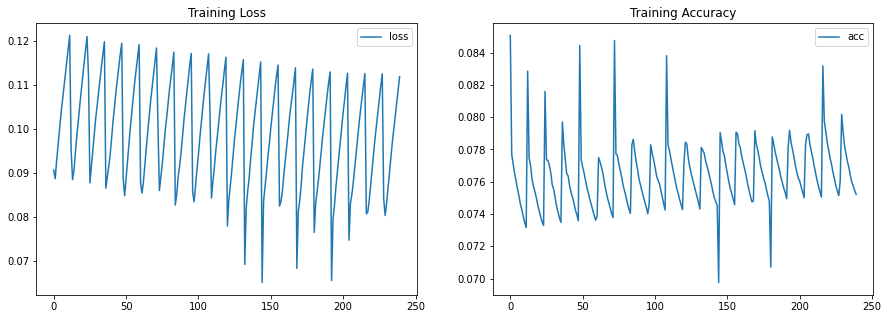

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

## CKPT-2 Model
End Accuracy - 24.68%  
This model is used for Predictions  

Parameters 
Trained on Smaller Dataset (before joins)   
NUM_SAMPLES = 50000  
EPOCHS = 100  
D_MODEL = 512  
N_LAYERS = 6  
FFN_UNITS = 2048  
N_HEADS = 8  
DROPOUT_RATE = 0.2  
Batch Size - 64*4  

In [ ]:
# trained on the smaller dataset - before joining

losses, accuracies = main_train(dataset, transformer, 100, 100)

Starting epoch 1
Epoch 1 Batch 0 Loss 2.6092 Accuracy 0.0000
Epoch 1 Batch 100 Loss 2.4358 Accuracy 0.0280
Saving checkpoint for epoch 1 in ../content/gdrive/MyDrive/ckpt-2/ckpt-1
Time to complete epoch: 1.51 mins
Accuracy ended as 0.0282 

Starting epoch 2
Epoch 2 Batch 0 Loss 2.2218 Accuracy 0.0345
Epoch 2 Batch 100 Loss 2.1135 Accuracy 0.0374
Saving checkpoint for epoch 2 in ../content/gdrive/MyDrive/ckpt-2/ckpt-2
Time to complete epoch: 1.51 mins
Accuracy ended as 0.0379 

Starting epoch 3
Epoch 3 Batch 0 Loss 1.8717 Accuracy 0.0636
Epoch 3 Batch 100 Loss 1.6873 Accuracy 0.0699
Saving checkpoint for epoch 3 in ../content/gdrive/MyDrive/ckpt-2/ckpt-3
Time to complete epoch: 1.48 mins
Accuracy ended as 0.0701 

Starting epoch 4
Epoch 4 Batch 0 Loss 1.5491 Accuracy 0.0808
Epoch 4 Batch 100 Loss 1.4493 Accuracy 0.0864
Saving checkpoint for epoch 4 in ../content/gdrive/MyDrive/ckpt-2/ckpt-4
Time to complete epoch: 1.48 mins
Accuracy ended as 0.0865 

Starting epoch 5
Epoch 5 Batch 0 Los

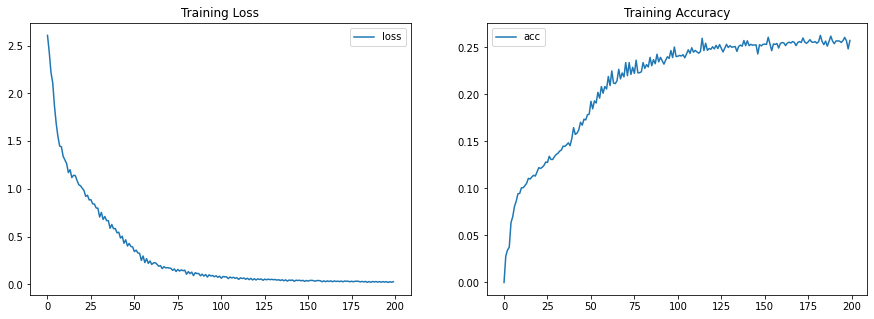

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

## CKPT-3 Model
End Accuracy - 7.61% 
   
__Parameters__    
NUM_SAMPLES = 40000  
D_MODEL = 128  
N_LAYERS = 6  
FFN_UNITS = 512  
N_HEADS = 8  
DROPOUT_RATE = 0.1  
BATCH_SIZE = 64*2  

In [ ]:
"""
epochs 1 to 100
This is a model with the same dataset as ckpt-1, but with a much smaller model, to see how 
parameter adjustments impact training and outcome
checkpoint at each epoch will allow the model to have no issues down the line
"""

losses, accuracies = main_train(dataset, transformer, 100, 100)

Starting epoch 1
Epoch 1 Batch 0 Loss 0.9802 Accuracy 0.0000
Epoch 1 Batch 100 Loss 0.9351 Accuracy 0.0058
Epoch 1 Batch 200 Loss 0.9194 Accuracy 0.0079
Epoch 1 Batch 300 Loss 0.8886 Accuracy 0.0087
Epoch 1 Batch 400 Loss 0.8516 Accuracy 0.0092
Epoch 1 Batch 500 Loss 0.8139 Accuracy 0.0096
Saving checkpoint for epoch 1 in ../content/gdrive/MyDrive/ckpt-3/ckpt-1
Time to complete epoch: 5.40 mins
Accuracy ended as 0.0098 

Starting epoch 2
Epoch 2 Batch 0 Loss 0.6230 Accuracy 0.0118
Epoch 2 Batch 100 Loss 0.5959 Accuracy 0.0146
Epoch 2 Batch 200 Loss 0.5811 Accuracy 0.0172
Epoch 2 Batch 300 Loss 0.5681 Accuracy 0.0193
Epoch 2 Batch 400 Loss 0.5571 Accuracy 0.0208
Epoch 2 Batch 500 Loss 0.5477 Accuracy 0.0219
Saving checkpoint for epoch 2 in ../content/gdrive/MyDrive/ckpt-3/ckpt-2
Time to complete epoch: 5.31 mins
Accuracy ended as 0.0226 

Starting epoch 3
Epoch 3 Batch 0 Loss 0.4597 Accuracy 0.0281
Epoch 3 Batch 100 Loss 0.4861 Accuracy 0.0288
Epoch 3 Batch 200 Loss 0.4820 Accuracy 0.02

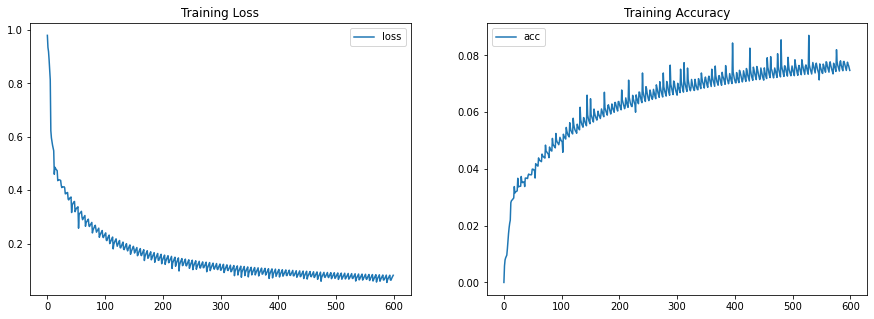

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

In [ ]:
# lets find a random example from the dataset using the random module to test the accuracy of this sentence
index = random.randint(0, len(en_array))

#print(en_array[index], "\n", zh_array[index])

# show a translation from the dataset
sentence = en_array[index]
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Expected sentence: {}".format(zh_array[index]))
print("Output sentence:   {} \n".format(predicted_sentence))

# set-up for BLEU sentence level eval
reference = str(zh_array[index].split())
candidate = predicted_sentence.split()

smoothie = SmoothingFunction().method7
score = sentence_bleu(reference, candidate)
print("BLEU Sentence Score: {:.2f}".format(score))
print("Reference:", reference)
print("Candidate:", candidate)

Input sentence: bf: that's all right, he does that. all right.
Expected sentence: BF :   好 ， 他 做 那个 ， 好 的
Output sentence:   BF :   好 ， 他 做 那个 ， 好 的 

BLEU Sentence Score: 0.88
Reference: ['BF', ':', '好', '，', '他', '做', '那个', '，', '好', '的']
Candidate: ['BF', ':', '好', '，', '他', '做', '那个', '，', '好', '的']


In [ ]:
# sentence not from dataset

sentence = "what do you want to EAT?".lower()
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
#print("Expected sentence: {}".format(zh_array[index]))
print("Output sentence:   {} \n".format(predicted_sentence))

Input sentence: what do you want to eat?
Output sentence:   你 想 吃 什麼 ? 



## CKPT-4 Model
End Accuracy - 7.00%  

__Parameters__   
NUM_SAMPLES = 40000  
D_MODEL = 128  
N_LAYERS = 6  
FFN_UNITS = 512  
N_HEADS = 8  
DROPOUT_RATE = 0.1  
BATCH_SIZE = 64*2  

In [ ]:
"""
epochs 1 to 100 - adjusted dataset (removed numbers and links)
This is a model with a different dataset, but the same settings as ckpt-3, 
it is a much smaller model, to see how parameter adjustments impact training and outcome
checkpoint at each epoch will allow the model to have no issues down the line
in case of any sudden power loss or disconnections
"""

losses, accuracies = main_train(dataset, transformer, 100, 100)

Starting epoch 1
Epoch 1 Batch 0 Loss 0.9446 Accuracy 0.0000
Epoch 1 Batch 100 Loss 0.9083 Accuracy 0.0056
Epoch 1 Batch 200 Loss 0.8865 Accuracy 0.0079
Epoch 1 Batch 300 Loss 0.8567 Accuracy 0.0086
Epoch 1 Batch 400 Loss 0.8179 Accuracy 0.0090
Epoch 1 Batch 500 Loss 0.7817 Accuracy 0.0092
Saving checkpoint for epoch 1 in ../content/gdrive/MyDrive/ckpt-4/ckpt-1
Time to complete epoch: 5.52 mins
Accuracy ended as 0.0094 

Starting epoch 2
Epoch 2 Batch 0 Loss 0.5658 Accuracy 0.0126
Epoch 2 Batch 100 Loss 0.5828 Accuracy 0.0142
Epoch 2 Batch 200 Loss 0.5667 Accuracy 0.0166
Epoch 2 Batch 300 Loss 0.5555 Accuracy 0.0181
Epoch 2 Batch 400 Loss 0.5469 Accuracy 0.0192
Epoch 2 Batch 500 Loss 0.5392 Accuracy 0.0201
Saving checkpoint for epoch 2 in ../content/gdrive/MyDrive/ckpt-4/ckpt-2
Time to complete epoch: 5.45 mins
Accuracy ended as 0.0205 

Starting epoch 3
Epoch 3 Batch 0 Loss 0.4736 Accuracy 0.0245
Epoch 3 Batch 100 Loss 0.4838 Accuracy 0.0253
Epoch 3 Batch 200 Loss 0.4807 Accuracy 0.02

In [ ]:
"""
epochs 101 to 200 - adjusted dataset (removed numbers and links)
This is a model with a different dataset, but the same settings as ckpt-3, 
it is a much smaller model, to see how parameter adjustments impact training and outcome
checkpoint at each epoch will allow the model to have no issues down the line
in case of any sudden power loss or disconnections

PARAMETERS USED
NUM_SAMPLES = 40000
D_MODEL = 128
N_LAYERS = 6
FFN_UNITS = 512
N_HEADS = 8
DROPOUT_RATE = 0.1
BATCH_SIZE = 64*2
"""

losses, accuracies = main_train(dataset, transformer, 100, 100)

Epoch 1 Batch 0 Loss 0.0505 Accuracy 0.0788
Epoch 1 Batch 100 Loss 0.0592 Accuracy 0.0757
Epoch 1 Batch 200 Loss 0.0640 Accuracy 0.0748
Epoch 1 Batch 300 Loss 0.0685 Accuracy 0.0738
Epoch 1 Batch 400 Loss 0.0726 Accuracy 0.0731
Epoch 1 Batch 500 Loss 0.0763 Accuracy 0.0723
Saving checkpoint for epoch 1 in ../content/gdrive/MyDrive/ckpt-4/ckpt-101
Time to complete epoch: 5.93 mins
Accuracy ended as 0.0721 

Starting epoch 2
Epoch 2 Batch 0 Loss 0.0563 Accuracy 0.0813
Epoch 2 Batch 100 Loss 0.0598 Accuracy 0.0760
Epoch 2 Batch 200 Loss 0.0640 Accuracy 0.0748
Epoch 2 Batch 300 Loss 0.0682 Accuracy 0.0739
Epoch 2 Batch 400 Loss 0.0721 Accuracy 0.0732
Epoch 2 Batch 500 Loss 0.0759 Accuracy 0.0724
Saving checkpoint for epoch 2 in ../content/gdrive/MyDrive/ckpt-4/ckpt-102
Time to complete epoch: 5.42 mins
Accuracy ended as 0.0721 

Starting epoch 3
Epoch 3 Batch 0 Loss 0.0541 Accuracy 0.0712
Epoch 3 Batch 100 Loss 0.0593 Accuracy 0.0758
Epoch 3 Batch 200 Loss 0.0636 Accuracy 0.0749
Epoch 3 Ba

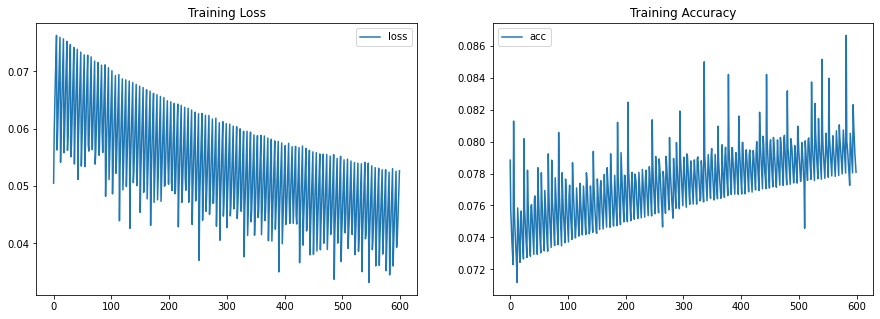

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

In [ ]:
# lets find a random example from the dataset using the random module to test the accuracy of this sentence
index = random.randint(0, len(en_array))

#print(en_array[index], "\n", zh_array[index])

# show a translation from the dataset
sentence = en_array[index]
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Expected sentence: {}".format(zh_array[index]))
print("Output sentence:   {} \n".format(predicted_sentence))

# set-up for BLEU sentence level eval
reference = str(zh_array[index].split())
candidate = predicted_sentence.split()

smoothie = SmoothingFunction().method7
score = sentence_bleu(reference, candidate)
print("BLEU Sentence Score: {:.2f}".format(score))
print("Reference:", reference)
print("Candidate:", candidate)

Input sentence: it's very different from the medical model.
Expected sentence: 这 与 医学 模式 非常 不同 。
Output sentence:   这 与 医学 模式 非常 不同 。 

BLEU Sentence Score: 0.81
Reference: ['这', '与', '医学', '模式', '非常', '不同', '。']
Candidate: ['这', '与', '医学', '模式', '非常', '不同', '。']


In [ ]:
# sentence not from dataset

sentence = "do we have any snacks in the refrigerator?".lower()
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
#print("Expected sentence: {}".format(zh_array[index]))
print("Output sentence:   {} \n".format(predicted_sentence))

Input sentence: do we have any snacks in the refrigerator?
Output sentence:   我们 冰箱 里 有 什么 雨伞 机器 ？ 



## Model 5
End Accuracy - 16.01%  
This model is used for predictions  

__Parameters__  
NUM_SAMPLES = 50000  
D_MODEL = 512  
N_LAYERS = 6  
FFN_UNITS = 2048  
N_HEADS = 8  
DROPOUT_RATE = 0.2  
Batch Size - 128  
Max Length - 50  


In [ ]:
""" model-5 folder
epochs 1 to 76
lets split them up to reach the final goal for inference testing and eval

checkpoint at each epoch will allow the model to have no issues down the line
"""

losses, accuracies = main_train(dataset, transformer, 200, 100)

Starting epoch 1
Epoch 1 Batch 0 Loss 1.9564 Accuracy 0.0000
Epoch 1 Batch 100 Loss 1.7790 Accuracy 0.0157
Epoch 1 Batch 200 Loss 1.6872 Accuracy 0.0181
Epoch 1 Batch 300 Loss 1.5826 Accuracy 0.0191
Epoch 1 Batch 400 Loss 1.4894 Accuracy 0.0222
Epoch 1 Batch 500 Loss 1.4218 Accuracy 0.0255
Saving checkpoint for epoch 1 in ../content/gdrive/MyDrive/model-5/ckpt-1
Time to complete epoch: 7.00 mins
Accuracy ended as 0.0269 

Starting epoch 2
Epoch 2 Batch 0 Loss 1.1412 Accuracy 0.0450
Epoch 2 Batch 100 Loss 1.0771 Accuracy 0.0437
Epoch 2 Batch 200 Loss 1.0591 Accuracy 0.0452
Epoch 2 Batch 300 Loss 1.0494 Accuracy 0.0462
Epoch 2 Batch 400 Loss 1.0384 Accuracy 0.0473
Epoch 2 Batch 500 Loss 1.0290 Accuracy 0.0483
Saving checkpoint for epoch 2 in ../content/gdrive/MyDrive/model-5/ckpt-2
Time to complete epoch: 6.93 mins
Accuracy ended as 0.0487 

Starting epoch 3
Epoch 3 Batch 0 Loss 0.8782 Accuracy 0.0489
Epoch 3 Batch 100 Loss 0.9322 Accuracy 0.0542
Epoch 3 Batch 200 Loss 0.9332 Accuracy 0.

crashed caused due to usage limits, the below run is used to regenerate the model from the sudden stop

In [ ]:
losses, accuracies = main_train(dataset, transformer, 1, 100)

Starting epoch 1
Epoch 1 Batch 0 Loss 0.0999 Accuracy 0.1578
Epoch 1 Batch 100 Loss 0.1145 Accuracy 0.1531
Epoch 1 Batch 200 Loss 0.1203 Accuracy 0.1511
Epoch 1 Batch 300 Loss 0.1272 Accuracy 0.1498
Epoch 1 Batch 400 Loss 0.1341 Accuracy 0.1485
Epoch 1 Batch 500 Loss 0.1415 Accuracy 0.1471
Saving checkpoint for epoch 1 in ../content/gdrive/MyDrive/model-5/ckpt-77
Time to complete epoch: 9.26 mins
Accuracy ended as 0.1464 



In [ ]:
""" model-5 folder
epochs 77 to 100
lets split them up to reach the final goal for inference testing and eval

checkpoint at each epoch will allow the model to have no issues down the line
"""
epochs = 100-77

losses, accuracies = main_train(dataset, transformer, epochs, 100)

Starting epoch 1
Epoch 1 Batch 0 Loss 0.1091 Accuracy 0.1626
Epoch 1 Batch 100 Loss 0.1125 Accuracy 0.1530
Epoch 1 Batch 200 Loss 0.1187 Accuracy 0.1515
Epoch 1 Batch 300 Loss 0.1263 Accuracy 0.1501
Epoch 1 Batch 400 Loss 0.1336 Accuracy 0.1486
Epoch 1 Batch 500 Loss 0.1409 Accuracy 0.1473
Saving checkpoint for epoch 1 in ../content/gdrive/MyDrive/model-5/ckpt-78
Time to complete epoch: 5.97 mins
Accuracy ended as 0.1466 

Starting epoch 2
Epoch 2 Batch 0 Loss 0.1003 Accuracy 0.1582
Epoch 2 Batch 100 Loss 0.1132 Accuracy 0.1537
Epoch 2 Batch 200 Loss 0.1179 Accuracy 0.1520
Epoch 2 Batch 300 Loss 0.1249 Accuracy 0.1506
Epoch 2 Batch 400 Loss 0.1315 Accuracy 0.1491
Epoch 2 Batch 500 Loss 0.1390 Accuracy 0.1477
Saving checkpoint for epoch 2 in ../content/gdrive/MyDrive/model-5/ckpt-79
Time to complete epoch: 5.97 mins
Accuracy ended as 0.1470 

Starting epoch 3
Epoch 3 Batch 0 Loss 0.1145 Accuracy 0.1590
Epoch 3 Batch 100 Loss 0.1113 Accuracy 0.1547
Epoch 3 Batch 200 Loss 0.1171 Accuracy 

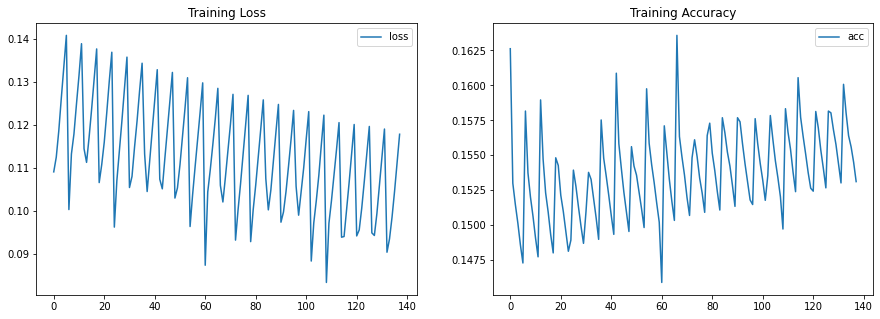

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

In [ ]:
# lets find a random example from the dataset using the random module to test the accuracy of this sentence
index = random.randint(0, len(en_array))

#print(en_array[index], "\n", zh_array[index])

# show a translation from the dataset
sentence = en_array[index]
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Expected sentence: {}".format(zh_array[index]))
print("Output sentence:   {} \n".format(predicted_sentence))

# set-up for BLEU sentence level eval
reference = str(zh_array[index].split())
candidate = predicted_sentence.split()

smoothie = SmoothingFunction().method4
score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
print("BLEU Sentence Score: {:.2f}".format(score))
print("Reference:", reference)
print("Candidate:", candidate)

Input sentence: but this is the source of innovation.
Expected sentence: 但 这 就是 创新 的 能力 。
Output sentence:   但 这 就是 创新 的 能力 。 

BLEU Sentence Score: 0.28
Reference: ['但', '这', '就是', '创新', '的', '能力', '。']
Candidate: ['但', '这', '就是', '创新', '的', '能力', '。']


In [ ]:
# sentence not from dataset

sentence = "it was like poetry"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
#print("Expected sentence: {}".format(zh_array[index]))
print("Output sentence:   {} \n".format(predicted_sentence))

Input sentence: it was like poetry
Output sentence:   是 个 纸唱 



In [ ]:
%%time

test_list = []
sentences = en_array_test

index = 0
for i in sentences:
    translation = translate(i)
    test_list.append(translation)
    #print(translate(i))

print(len(test_list))
from nltk.translate.bleu_score import corpus_bleu

smoothie = SmoothingFunction().method4
test_bleu_score = corpus_bleu(list1, zh_array[:5000])
print(test_bleu_score)

In [ ]:
print(len(list1))

3422


In [ ]:
zh_array[:30]

array(['嗨 。', '你好 。', '你 用 跑 的 。', '等等 ！', '等 一下 ！', '开始 ！', '你好 。',
       '我 试试 。', '我 赢 了 。', '不会 吧 。', '乾杯 !', '你 懂 了 吗 ？', '他 跑 了 。',
       '跳进来 。', '我 知道 。', '我 退出 。', '我 不 干 了 。', '我 沒事 。', '我 已经 起来 了 。',
       '听 着 。', '不 可能 ！', '没门 ！', '你 确定 ？', '谢谢 ！', '试试 吧 。', '我们 来 试试 。',
       '为什么 是 我 ？', '去 问 汤姆 。', '好棒 ！', '冷静 点 。'], dtype='<U195')

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

smoothie = SmoothingFunction().method4
score2 = corpus_bleu(list1, zh_array[:5000])
print(score2)

0.9136565422864902


## Model 6
End Accuracy - 14.88%  
Not used for Predictions as is only 50 epochs  

__Parameters__  
NUM_SAMPLES = 50000  
D_MODEL = 512  
N_LAYERS = 6  
FFN_UNITS = 2048  
N_HEADS = 8  
DROPOUT_RATE = 0.2  
Batch Size - 128  
Max Length - 50  

In [ ]:
""" model-6 folder
epochs 1 to 50
checkpoint at each epoch will allow the model to have no issues down the line
usage limits sometimes occur, due to using colab for a stronger GPU, so if that happens we can retain up to the latest checkpoint
"""

losses, accuracies = main_train(dataset, transformer, 50, 250)

Starting epoch 1
Epoch 1 Batch 0 Loss 2.1727 Accuracy 0.0000
Epoch 1 Batch 250 Loss 2.0380 Accuracy 0.0183
Epoch 1 Batch 500 Loss 1.7778 Accuracy 0.0246
Saving checkpoint for epoch 1 in ../content/gdrive/MyDrive/model-6/ckpt-1
Time to complete epoch: 7.22 mins
Accuracy ended as 0.0283 

Starting epoch 2
Epoch 2 Batch 0 Loss 1.2975 Accuracy 0.0480
Epoch 2 Batch 250 Loss 1.3108 Accuracy 0.0495
Epoch 2 Batch 500 Loss 1.2857 Accuracy 0.0519
Saving checkpoint for epoch 2 in ../content/gdrive/MyDrive/model-6/ckpt-2
Time to complete epoch: 7.25 mins
Accuracy ended as 0.0529 

Starting epoch 3
Epoch 3 Batch 0 Loss 1.2065 Accuracy 0.0553
Epoch 3 Batch 250 Loss 1.1801 Accuracy 0.0591
Epoch 3 Batch 500 Loss 1.1696 Accuracy 0.0601
Saving checkpoint for epoch 3 in ../content/gdrive/MyDrive/model-6/ckpt-3
Time to complete epoch: 7.22 mins
Accuracy ended as 0.0604 

Starting epoch 4
Epoch 4 Batch 0 Loss 1.0734 Accuracy 0.0673
Epoch 4 Batch 250 Loss 1.0983 Accuracy 0.0639
Epoch 4 Batch 500 Loss 1.1016

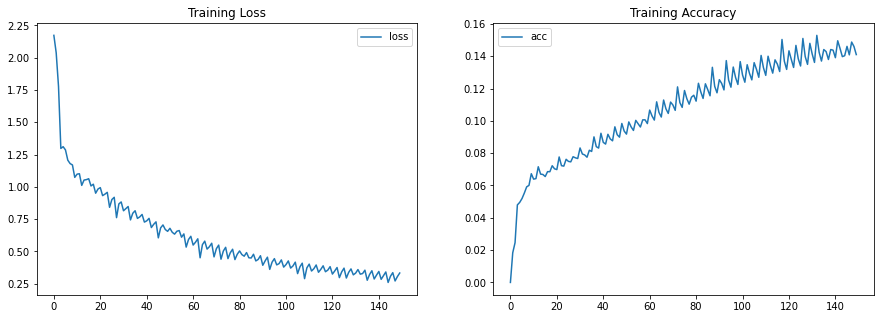

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

In [ ]:
# lets find a random example from the test dataset using the random module to test the accuracy of the sentence
index = random.randint(0, len(en_array_test))

# show a translation from the test dataset
sentence = en_array_test[index]
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Expected sentence: {}".format(zh_array_test[index]))
print("Output sentence:   {} \n".format(predicted_sentence))

# set-up for BLEU sentence level eval
reference = str(zh_array_test[index].split())
candidate = predicted_sentence.split()

smoothie = SmoothingFunction().method4
score = sentence_bleu(reference, candidate)
print("BLEU Sentence Score: {:.2f}".format(score))
print("Reference:", reference)
print("Candidate:", candidate)

Input sentence: architecture,book,culture,design,entertainment,men
Expected sentence: architecture , book , culture , design , entertainment , men
Output sentence:   architecture , arts , culture , design , education 

BLEU Sentence Score: 0.58
Reference: ['architecture', ',', 'book', ',', 'culture', ',', 'design', ',', 'entertainment', ',', 'men']
Candidate: ['architecture', ',', 'arts', ',', 'culture', ',', 'design', ',', 'education']


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


## Model 7 
End Accuracy - 20.61%  
(model-2 in folder)  
This model is used for Predictions

__Parameters__  
NUM_SAMPLES = 50000  
D_MODEL = 512  
N_LAYERS = 6  
FFN_UNITS = 1024   
N_HEADS = 8  
DROPOUT_RATE = 0.2  
Batch Size - 128  
Max Length - 50  

In [ ]:
""" 
epochs 1 to 100
checkpoint at each epoch will allow the model to have no issues down the line
usage limits sometimes occur, due to using colab for a stronger GPU, so if that happens we can retain up to the latest checkpoint
"""

losses, accuracies = main_train(dataset, transformer, 100, 250)

Starting epoch 1
Epoch 1 Batch 0 Loss 2.3792 Accuracy 0.0000
Epoch 1 Batch 250 Loss 2.0266 Accuracy 0.0188
Epoch 1 Batch 500 Loss 1.7676 Accuracy 0.0260
Saving checkpoint for epoch 1 in ../content/gdrive/MyDrive/model-2/ckpt-1
Time to complete epoch: 8.04 mins
Accuracy ended as 0.0298 

Starting epoch 2
Epoch 2 Batch 0 Loss 1.3787 Accuracy 0.0493
Epoch 2 Batch 250 Loss 1.2952 Accuracy 0.0517
Epoch 2 Batch 500 Loss 1.2668 Accuracy 0.0543
Saving checkpoint for epoch 2 in ../content/gdrive/MyDrive/model-2/ckpt-2
Time to complete epoch: 7.96 mins
Accuracy ended as 0.0553 

Starting epoch 3
Epoch 3 Batch 0 Loss 1.1010 Accuracy 0.0598
Epoch 3 Batch 250 Loss 1.1466 Accuracy 0.0621
Epoch 3 Batch 500 Loss 1.1405 Accuracy 0.0630
Saving checkpoint for epoch 3 in ../content/gdrive/MyDrive/model-2/ckpt-3
Time to complete epoch: 7.92 mins
Accuracy ended as 0.0634 

Starting epoch 4
Epoch 4 Batch 0 Loss 1.0427 Accuracy 0.0740
Epoch 4 Batch 250 Loss 1.0645 Accuracy 0.0675
Epoch 4 Batch 500 Loss 1.0662

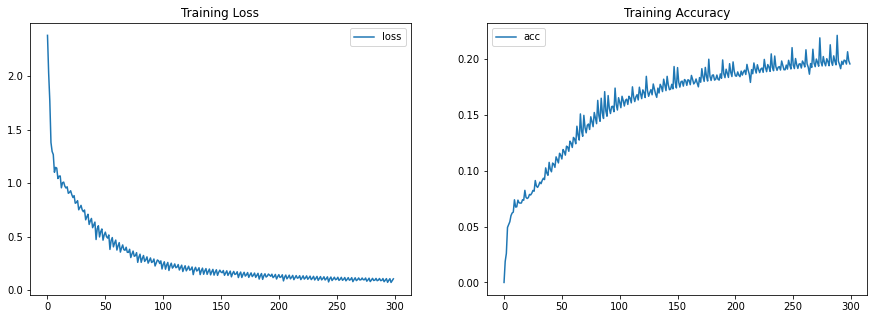

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

In [ ]:
# lets find a random example from the test dataset using the random module to test the accuracy of the sentence
index = random.randint(0, len(en_array_test))

# show a translation from the test dataset
sentence = en_array_test[index]
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Expected sentence: {}".format(zh_array_test[index]))
print("Output sentence:   {} \n".format(predicted_sentence))

# set-up for BLEU sentence level eval
reference = str(zh_array_test[index].split())
candidate = predicted_sentence.split()

smoothie = SmoothingFunction().method4
score = sentence_bleu(reference, candidate)
print("BLEU Sentence Score: {:.2f}".format(score))
print("Reference:", reference)
print("Candidate:", candidate)

Input sentence: we didn't have much rain last month.
Expected sentence: 上個 月 我們 這兒 沒 有 下 很多 雨 。
Output sentence:   很多 時候 沒 有 很 久 。 

BLEU Sentence Score: 0.87
Reference: ['上個', '月', '我們', '這兒', '沒', '有', '下', '很多', '雨', '。']
Candidate: ['很多', '時候', '沒', '有', '很', '久', '。']


# Predictions

In [ ]:
# lets find an example from the dataset to test the accuracy of this sentence
index = 11000
print(en_array[index], "\n", zh_array[index])

i didn't know where it came from. 
 我 不 知道 它 是从 哪里 来 的 。


In [ ]:
# show a translation from the dataset
sentence = en_array[index]
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence:   {}".format(predicted_sentence))
print("Expected sentence: {}".format(zh_array[index]))

In [ ]:
#Show a translation not from the dataset
sentence = "i have many questions that you need to answer"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: i have many questions that you need to answer
Output sentence: 我 需要 知道 你 一个 努力 的 問題 。


In [ ]:
reference = str(zh_array[index].split())
candidate = predicted_sentence.split()

smoothie = SmoothingFunction().method7
score = sentence_bleu(reference, candidate)
print("BLEU Sentence Score: {:.5f}".format(score))
print("Reference:", reference)
print("Candidate:", candidate)

BLEU Sentence Score: 0.86944
Reference: ['我', '可以', '再', '要些', '咖啡', '嗎', '？']
Candidate: ['我', '可以', '再', '要些', '咖啡', '嗎', '？']


In [ ]:
gc.collect()

770

## WER - Word Error Rate
the function for computing WER is loaded here

In [4]:
def wer_score(hyp, ref, print_matrix=False):
  N = len(hyp)
  M = len(ref)
  L = np.zeros((N,M))
  for i in range(0, N):
    for j in range(0, M):
      if min(i,j) == 0:
        L[i,j] = max(i,j)
      else:
        deletion = L[i-1,j] + 1
        insertion = L[i,j-1] + 1
        sub = 1 if hyp[i] != ref[j] else 0
        substitution = L[i-1,j-1] + sub
        L[i,j] = min(deletion, min(insertion, substitution))
        # print("{} - {}: del {} ins {} sub {} s {}".format(hyp[i], ref[j], deletion, insertion, substitution, sub))
  if print_matrix:
    print("WER matrix ({}x{}): ".format(N, M))
    print(L)
  return int(L[N-1, M-1])

## CKPT-2 Predictions and Testing
smaller model trained on a reduced size dataset  
double the batch size

### Setting up the Train and Test Datasets

In [ ]:
"""
ckpt-2 model checks
"""

# model-2 training set predictions

# lets find a random example from the test dataset using the random module to test the accuracy of the sentence
index = random.randint(0, len(prediction_test_df_ckpt2))

# show a translation from the test dataset
sentence = prediction_test_df_ckpt2['Source'][index]
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
#predicted_sentence = translate(sentence)
print("Expected sentence: {}".format((prediction_test_df_ckpt2['Reference'][index].replace(" ", ""))))
print("Output sentence:   {} \n".format(predicted_sentence.replace(" ","")))

# set-up for BLEU sentence level eval
reference = str(prediction_test_df_ckpt2['Reference'][index].split())
candidate = predicted_sentence.split()

smoothie = SmoothingFunction().method4
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0.0, 0.0), smoothing_function=smoothie)
print("BLEU Sentence Score: {:.2f}".format(score))
print("Reference:", reference)
print("Candidate:", candidate)
print("\nSentence Index:", index)

In [ ]:
%%time

"""
CKPT-2 BLEU Corpus Test
w/ train + test
"""

train_list = []
sentences = en_array[:15000]

for i in sentences:
    translation = translate(i)
    train_list.append(translation)

CPU times: user 7h 4min 11s, sys: 24min 27s, total: 7h 28min 39s
Wall time: 6h 41min 32s


In [ ]:
prediction_train_df_ckpt2 = pd.DataFrame({"Candidate": [], "Reference": [], "Source": []})

for i in train_list:
    prediction_train_df_ckpt2["Candidate"] = train_list
    prediction_train_df_ckpt2["Reference"] = zh_array[:15000]
    prediction_train_df_ckpt2["Source"]    = en_array[:15000]

In [ ]:
#prediction_train_df_ckpt2.to_csv("../content/gdrive/MyDrive/NMT-files/model-ckpt-2_prediction_train_data.csv", index=False)
prediction_train_df_ckpt2 = pd.read_csv("../content/gdrive/MyDrive/NMT-files/model-ckpt-2_prediction_train_data.csv")

In [ ]:
prediction_train_df_ckpt2.sample(10)

,Candidate,Reference,Source
10978,太熱 了 所以 我們 無法 工作 。,太熱 了 所以 我們 無法 工作 。,it's too hot for us to work.
9695,我 跟不上 汤姆 的 逻辑 。,我 跟不上 汤姆 的 逻辑 。,i can't follow tom's logic.
4390,嗨 ！ 你 在 这儿 工作 吗 ？,嗨 ！ 你 在 这儿 工作 吗 ？,hi! do you work here?
7184,那 就是 你 ， 不是 么 ？,那 就是 你 ， 不是 么 ？,"that was you, wasn't it?"
1911,他 最近 去世 了 。,他 最近 去世 了 。,he died recently.
6731,他 厌倦 了 读书 。,他 厌倦 了 读书 。,he got tired of reading.
2,你 用 跑 的 。,你 用 跑 的 。,run.
4248,你 是 湯姆 的 母親 嗎 ？,你 是 湯姆 的 母親 嗎 ？,are you tom's mother?
7410,什么 时候 开始 ？,什么 时候 开始 ？,what time does it start?
4374,他 以前 住 在 这儿 。,他 以前 住 在 这儿 。,he used to live here.


In [ ]:
smoothie = SmoothingFunction().method7
test_bleu_score = corpus_bleu(prediction_train_df_ckpt2['Reference'], prediction_train_df_ckpt2['Candidate'], smoothing_function=smoothie)
print("Corpus BLEU Score Train {:.2f}".format(test_bleu_score*100))

Corpus BLEU Score Train 40.02


Set up the test dataset translations as a file so it's faster to evaluate in later sessions

In [ ]:
prediction_test_df = pd.read_csv("../content/gdrive/MyDrive/NMT-files/model2_prediction_data.csv")

In [ ]:
%%time

"""
CKPT-2 BLEU Corpus Test
w/ train + test
"""

test_list = []
sentences = prediction_test_df['Source'][:15000]

counter = 0
n = 1000
for i in sentences:
    counter +=1
    if counter % n == 0:
        print("counter has reached:", counter)
    translation = translate(i)
    test_list.append(translation)

counter has reached: 1000
counter has reached: 2000
counter has reached: 3000
counter has reached: 4000
counter has reached: 5000
counter has reached: 6000
counter has reached: 7000
counter has reached: 8000
counter has reached: 9000
counter has reached: 10000
counter has reached: 11000
counter has reached: 12000
counter has reached: 13000
counter has reached: 14000
counter has reached: 15000
CPU times: user 10h 54min 22s, sys: 2h 22min 2s, total: 13h 16min 24s
Wall time: 10h 51min 51s


In [ ]:
prediction_test_df_ckpt2 = pd.DataFrame({"Candidate": [], "Reference": [], "Source": []})

for i in test_list:
    prediction_test_df_ckpt2["Candidate"] = test_list
    prediction_test_df_ckpt2["Reference"] = prediction_test_df['Reference']
    prediction_test_df_ckpt2["Source"]    = prediction_test_df['Source']

save 15000 predictions for model CKPT-2 from the test dataset for later use

In [ ]:
#prediction_test_df_ckpt2.to_csv("../content/gdrive/MyDrive/NMT-files/model-ckpt-2_prediction_test_data.csv", index=False)
prediction_test_df_ckpt2 = pd.read_csv("../content/gdrive/MyDrive/NMT-files/model-ckpt-2_prediction_test_data.csv")

### Load the files
Train and Test csv files

In [22]:
prediction_train_df_ckpt2 = pd.read_csv("../datasets/model-ckpt-2_prediction_train_data.csv")
prediction_test_df_ckpt2 = pd.read_csv("../datasets/model-ckpt-2_prediction_test_data.csv")

if len(prediction_train_df_ckpt2.columns) > 0:
    print("Training File Loaded")
if len(prediction_test_df_ckpt2.columns) > 0:
    print("Test File Loaded")

Training File Loaded
Test File Loaded


### BLEU

Training

In [ ]:
smoothie = SmoothingFunction().method7

# [actual, predicted, weights, smoothing function]

actual  = prediction_train_df_ckpt2['Reference']
predict = prediction_train_df_ckpt2['Candidate']

bleu_train_dict = {}

# dict for graphing
bleu_train_dict['1-grams']   = corpus_bleu(actual, predict, weights=(1,0,0,0), smoothing_function=smoothie)
bleu_train_dict['1-2-grams'] = corpus_bleu(actual, predict, weights=(0.5,0.5,0,0), smoothing_function=smoothie)
bleu_train_dict['1-3-grams'] = corpus_bleu(actual, predict, weights=(0.3,0.3,0.3,0), smoothing_function=smoothie)
bleu_train_dict['1-4-grams'] = corpus_bleu(actual, predict, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie)

# get scores for printing
train_bleu_score_1 = corpus_bleu(actual, predict, weights=(1,0,0,0), smoothing_function=smoothie)
train_bleu_score_2 = corpus_bleu(actual, predict, weights=(0.5,0.5,0,0), smoothing_function=smoothie)
train_bleu_score_3 = corpus_bleu(actual, predict, weights=(0.3,0.3,0.3,0), smoothing_function=smoothie)
train_bleu_score_4 = corpus_bleu(actual, predict, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie)

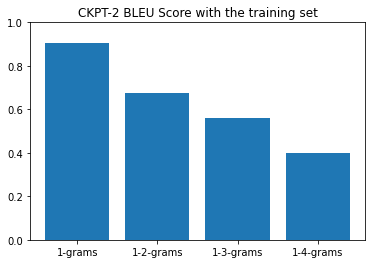


Corpus BLEU Score Train 1-1 N-Gram Weighting: 90.63
Corpus BLEU Score Train 1-2 N-Gram Weighting: 67.51
Corpus BLEU Score Train 1-3 N-Gram Weighting: 56.19
Corpus BLEU Score Train 1-4 N-Gram Weighting: 40.02


In [ ]:
# generate a graph to show the impact of weighting on BLEU score for test set
plt.bar(x = bleu_train_dict.keys(), height = bleu_train_dict.values())
plt.title("CKPT-2 BLEU Score with the training set")
plt.ylim((0,1))
plt.show()

# print n-gram scoring scores for train
print("\nCorpus BLEU Score Train 1-1 N-Gram Weighting: {:.2f}".format(train_bleu_score_1*100))
print("Corpus BLEU Score Train 1-2 N-Gram Weighting: {:.2f}".format(train_bleu_score_2*100))
print("Corpus BLEU Score Train 1-3 N-Gram Weighting: {:.2f}".format(train_bleu_score_3*100))
print("Corpus BLEU Score Train 1-4 N-Gram Weighting: {:.2f}".format(train_bleu_score_4*100))

Testing

In [ ]:
smoothie = SmoothingFunction().method7

# [actual, predicted, weights, smoothing function]

actual  = prediction_test_df_ckpt2['Reference']
predict = prediction_test_df_ckpt2['Candidate']

bleu_test_dict = {}

# dict for graphing
bleu_test_dict['1-grams']   = corpus_bleu(actual, predict, weights=(1,0,0,0), smoothing_function=smoothie)
bleu_test_dict['1-2-grams'] = corpus_bleu(actual, predict, weights=(0.5,0.5,0,0), smoothing_function=smoothie)
bleu_test_dict['1-3-grams'] = corpus_bleu(actual, predict, weights=(0.3,0.3,0.3,0), smoothing_function=smoothie)
bleu_test_dict['1-4-grams'] = corpus_bleu(actual, predict, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie)

# get scores for printing
test_bleu_score_1 = corpus_bleu(actual, predict, weights=(1,0,0,0), smoothing_function=smoothie)
test_bleu_score_2 = corpus_bleu(actual, predict, weights=(0.5,0.5,0,0), smoothing_function=smoothie)
test_bleu_score_3 = corpus_bleu(actual, predict, weights=(0.3,0.3,0.3,0), smoothing_function=smoothie)
test_bleu_score_4 = corpus_bleu(actual, predict, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie)

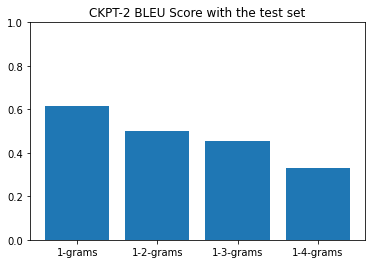


Corpus BLEU Score Test 1-1 N-Gram Weighting: 61.32
Corpus BLEU Score Test 1-2 N-Gram Weighting: 50.03
Corpus BLEU Score Test 1-3 N-Gram Weighting: 45.59
Corpus BLEU Score Test 1-4 N-Gram Weighting: 33.17


In [ ]:
# generate a graph to show the impact of weighting on BLEU score for test set
plt.bar(x = bleu_test_dict.keys(), height = bleu_test_dict.values())
plt.title("CKPT-2 BLEU Score with the test set")
plt.ylim((0,1))
plt.show()

# print n-gram scoring scores for train
print("\nCorpus BLEU Score Test 1-1 N-Gram Weighting: {:.2f}".format(test_bleu_score_1*100))
print("Corpus BLEU Score Test 1-2 N-Gram Weighting: {:.2f}".format(test_bleu_score_2*100))
print("Corpus BLEU Score Test 1-3 N-Gram Weighting: {:.2f}".format(test_bleu_score_3*100))
print("Corpus BLEU Score Test 1-4 N-Gram Weighting: {:.2f}".format(test_bleu_score_4*100))

### Word Error Rate
Training

In [5]:
# index = random.randint(0, len(actual)) 

actual  = prediction_train_df_ckpt2['Reference']
predict = prediction_train_df_ckpt2['Candidate']

# count how many sentences in the corpus have at least 1 incorrect word
count = 0
for i, j in zip(actual, predict):
    if wer_score(i, j, print_matrix=False) == 0:
        pass
    else:
        count += 1
print("Number of sentences with errors:", count)
print("Percentage of correct sentences: {:.2f}%".format(100-(count / len(actual) * 100)))

Number of sentences with errors: 1055
Percentage of correct sentences: 92.97%


Test

In [6]:
actual  = prediction_test_df_ckpt2['Reference']
predict = prediction_test_df_ckpt2['Candidate']

# count how many sentences in the corpus have at least 1 incorrect word
count = 0
for i, j in zip(actual, predict):
    if wer_score(i, j, print_matrix=False) == 0:
        pass
    else:
        count += 1
print("Number of sentences with errors:", count)
print("Percentage of correct sentences: {:.2f}%".format(100-(count / len(actual) * 100)))

Number of sentences with errors: 11423
Percentage of correct sentences: 23.85%


WER again but this time where there are at minimum 3 incorrect words

In [ ]:
actual  = prediction_test_df_ckpt2['Reference']
predict = prediction_test_df_ckpt2['Candidate']

# count how many sentences in the corpus have no more than 3 errors
count = 0
for i, j in zip(actual, predict):
    if wer_score(i, j, print_matrix=False) <= 3:
        pass
    else:
        count += 1
print("Number of sentences with errors:", count)
print("Percentage of correct sentences: {:.2f}%".format(100-(count / len(actual) * 100)))

Number of sentences with errors: 11240
Percentage of correct sentences: 25.07%


### Precision, Accuracy, Recall, F1 Score

In [ ]:
actual  = prediction_train_df_ckpt2['Reference']
predict = prediction_train_df_ckpt2['Candidate']

print('Accuracy: ', round(accuracy_score(actual, predict),2))
print('Precision:', round(precision_score(actual, predict, average='weighted', zero_division=0),2))
print('Recall:   ', round(recall_score(actual, predict, average='weighted', zero_division=0),2))
print('F! Score: ', round(f1_score(actual, predict, average='weighted', zero_division=0),2))

Accuracy:  0.93
Precision: 0.91
Recall:    0.93
F! Score:  0.91


In [ ]:
actual  = prediction_test_df_ckpt2['Reference']
predict = prediction_test_df_ckpt2['Candidate']

print('Accuracy: ', round(accuracy_score(actual, predict),2))
print('Precision:', round(precision_score(actual, predict, average='weighted', zero_division=0),2))
print('Recall:   ', round(recall_score(actual, predict, average='weighted', zero_division=0),2))
print('F! Score: ', round(f1_score(actual, predict, average='weighted', zero_division=0),2))

Accuracy:  0.24
Precision: 0.23
Recall:    0.24
F! Score:  0.23


### GLEU

Training

In [ ]:
# [[actual], predicted]

actual  = [prediction_train_df_ckpt2['Reference']]
predict = [prediction_train_df_ckpt2['Candidate']]

# get scores for printing
test_gleu_score = corpus_gleu([actual], predict)

print("Corpus GLEU Score Train: {:.2f}".format(test_gleu_score*100))

Corpus GLEU Score Train: 83.45


Testing

In [ ]:
# [[actual], predicted]

actual  = [prediction_test_df_ckpt2['Reference']]
predict = [prediction_test_df_ckpt2['Candidate']]

gleu_test_dict = {}

# get scores for printing
test_gleu_score = corpus_gleu([actual], predict)

print("Corpus GLEU Score Test: {:.2f}".format(test_gleu_score*100))

Corpus GLEU Score Test: 7.73


### NIST

Training

In [ ]:
# [[actual], predicted]

actual  = [prediction_train_df_ckpt2['Reference']]
predict = [prediction_train_df_ckpt2['Candidate']]

# get scores for printing
train_nist_score = corpus_nist([actual], predict)
print("Corpus NIST Score Train: {}".format(train_nist_score))

Corpus NIST Score Train: 1.4572787796244121e-05


Test

In [ ]:
# [[actual], predicted]

actual  = [prediction_test_df_ckpt2['Reference']]
predict = [prediction_test_df_ckpt2['Candidate']]

# get scores for printing
test_nist_score = corpus_nist([actual], predict)
print("Corpus NIST Score Test: {}".format(test_nist_score))

Corpus NIST Score Test: 0.00030476002199899914


### METEOR


Training

In [ ]:
index = random.randint(0, len(prediction_train_df_ckpt2))

actual  = prediction_train_df_ckpt2['Reference'][index]
predict = prediction_train_df_ckpt2['Candidate'][index]

print("Meteor Score for sentence", index, ":", round(meteor_score([actual], predict),4))

Meteor Score for sentence 14104 : 0.9977


In [ ]:
actual  = prediction_train_df_ckpt2['Reference']
predict = prediction_train_df_ckpt2['Candidate']

count = 0
for i, j in zip(actual, predict):
    if round(meteor_score([i], j), 1) > 0.5:
        count += 1
print("Sentences with a METEOR Score > 5:", count)

Sentences with a METEOR Score > 5: 14517


Test

In [ ]:
actual  = prediction_test_df_ckpt2['Reference']
predict = prediction_test_df_ckpt2['Candidate']

count = 0
for i, j in zip(actual, predict):
    if round(meteor_score([i], j), 1) > 0.5:
        count += 1
print("Sentences with a METEOR Score > 5:", count)

Sentences with a METEOR Score > 5: 3774


## Sentence Level Predictions

In [39]:
# model-ckpt-2 test set predictions

smoothie = SmoothingFunction().method7

actual  = prediction_test_df_ckpt2['Reference']
predict = prediction_test_df_ckpt2['Candidate']
source  = prediction_test_df_ckpt2['Source']

# lets find a random example from the test dataset using the random module to test the accuracy of the sentence
index = random.randint(0, len(actual))

# show a translation from the test dataset
sentence = source[index]
print("Input sentence: {}".format(sentence))
predicted_sentence = predict[index]
#predicted_sentence = translate(sentence)
print("Expected sentence: {}".format((actual[index].replace(" ", ""))))
print("Output sentence:   {} \n".format(predicted_sentence.replace(" ","")))

# set-up for BLEU sentence level eval
reference = actual[index].split()
candidate = predicted_sentence.split()

score = sentence_bleu(reference, candidate, weights=[1,0,0,0], smoothing_function=smoothie)
print("BLEU Sentence Score: {:.2f}".format(score))
print("Reference:", reference)
print("Candidate:", candidate)
print("\nSentence Index:", index)

Input sentence: i am happy to see you here.
Expected sentence: 我很高興在這裡看到你。
Output sentence:   我很高興在這裡看到你。 

BLEU Sentence Score: 0.76
Reference: ['我', '很', '高興', '在', '這裡', '看到', '你', '。']
Candidate: ['我', '很', '高興', '在', '這裡', '看到', '你', '。']

Sentence Index: 5064


## Model-5 Predictions and Testing

### Setting up the Train and Test datasets

In [ ]:
%%time

"""
Model-5 BLEU Corpus Test
w/ train + test
"""

train_list = []
sentences = en_array[:15000]

counter = 0
n = 500
for i in sentences:
    counter += 1
    if counter % n == 0:
        print("counter has reached:", counter)
    translation = translate(i)
    train_list.append(translation)

counter has reached: 500
counter has reached: 1000
counter has reached: 1500
counter has reached: 2000
counter has reached: 2500
counter has reached: 3000
counter has reached: 3500
counter has reached: 4000
counter has reached: 4500
counter has reached: 5000
counter has reached: 5500
counter has reached: 6000
counter has reached: 6500
counter has reached: 7000
counter has reached: 7500
counter has reached: 8000
counter has reached: 8500
counter has reached: 9000
counter has reached: 9500
counter has reached: 10000
counter has reached: 10500
counter has reached: 11000
counter has reached: 11500
counter has reached: 12000
counter has reached: 12500
counter has reached: 13000
counter has reached: 13500
counter has reached: 14000
counter has reached: 14500
counter has reached: 15000
CPU times: user 8h 43min 19s, sys: 59min 49s, total: 9h 43min 9s
Wall time: 7h 59min 9s


In [ ]:
prediction_train_df_model5 = pd.DataFrame({"Candidate": [], "Reference": [], "Source": []})

for i in train_list:
    prediction_train_df_model5["Candidate"] = train_list
    prediction_train_df_model5["Reference"] = zh_array[:15000]
    prediction_train_df_model5["Source"]    = en_array[:15000]

In [ ]:
#prediction_train_df_model5.to_csv("../content/gdrive/MyDrive/NMT-files/model-5_prediction_train_data.csv", index=False)
prediction_train_df_model5 = pd.read_csv("../content/gdrive/MyDrive/NMT-files/model-5_prediction_train_data.csv")

In [ ]:
prediction_train_df_model5.sample(10)

,Candidate,Reference,Source
5224,我 有 很多 才能 。,我 有 很多 才能 。,i have many abilities.
2029,我 沒 有 在 吼 。,我 沒 有 在 吼 。,i wasn't yelling.
11959,无论如何 说 不通 。,无论如何 说 不通 。,it makes no sense whatsoever.
6740,他 是 个 棒球 手 。,他 是 个 棒球 手 。,he is a baseball player.
13322,运动 有益健康 。,体育 有益健康 。,sport is good for your health.
1233,我 可以 用 那個 嗎 ?,我 可以 用 嗎 ？,may i use this?
1174,我 請 你 。,我 請 你 。,i'll treat you.
14797,這 可能 不是 真的 鑽石 。,這 可能 不是 真的 鑽石 。,this may not be a real diamond.
255,跟 著 他 走 。,跟 著 他 走 。,follow him.
6954,我 在 油管 上 看 它 。,我 在 油管 上 看 它 。,i watched it on youtube.


In [ ]:
prediction_test_df = pd.read_csv("../content/gdrive/MyDrive/NMT-files/model2_prediction_data.csv")

In [ ]:
%%time

"""
Model-5 BLEU Corpus Test
w/ train + test
"""

test_list = []
sentences = prediction_test_df['Source'][:15000]

counter = 0
n = 500
for i in sentences:
    counter +=1
    if counter % n == 0:
        print("counter has reached:", counter)
    translation = translate(i)
    test_list.append(translation)

counter has reached: 500
counter has reached: 1000
counter has reached: 1500
counter has reached: 2000
counter has reached: 2500
counter has reached: 3000
counter has reached: 3500
counter has reached: 4000
counter has reached: 4500
counter has reached: 5000
counter has reached: 5500
counter has reached: 6000
counter has reached: 6500
counter has reached: 7000
counter has reached: 7500
counter has reached: 8000
counter has reached: 8500
counter has reached: 9000
counter has reached: 9500
counter has reached: 10000
counter has reached: 10500
counter has reached: 11000
counter has reached: 11500
counter has reached: 12000
counter has reached: 12500
counter has reached: 13000
counter has reached: 13500
counter has reached: 14000
counter has reached: 14500
counter has reached: 15000
CPU times: user 15h 42min 6s, sys: 1h 17min 22s, total: 16h 59min 28s
Wall time: 13h 21min 55s


In [ ]:
prediction_test_df_model5 = pd.DataFrame({"Candidate": [], "Reference": [], "Source": []})

for i in test_list:
    prediction_test_df_model5["Candidate"] = test_list
    prediction_test_df_model5["Reference"] = prediction_test_df['Reference']
    prediction_test_df_model5["Source"]    = prediction_test_df['Source']

In [ ]:
#prediction_test_df_model5.to_csv("../content/gdrive/MyDrive/NMT-files/model-5_prediction_test_data.csv", index=False)
prediction_test_df_model5 = pd.read_csv("../content/gdrive/MyDrive/NMT-files/model-5_prediction_test_data.csv")

In [ ]:
prediction_test_df_model5.sample(10)

,Candidate,Reference,Source
12238,你 覺得 有 怎麼 會 說 ?,有 多少 人会 愿意 这么 说 ？,how many of you would be willing to say that?
11599,我 需要 相信 我们 的 自由 而 来,我 需要 的 就是 增长 知识 。,and what i need to develop is self-knowledge t...
12717,（ 笑声 ） 他 走进 一个 快餐店 。,（ 笑声 ） 他 走进 一个 快餐店 。,and he's going into a diner.
13728,那么 这个 肿瘤 里 的 神经 呢 ？,那么 这个 肿瘤 里 的 神经 呢 ？,what about the nerve that's going into this tu...
900,而 最 重要 的 发 没有 传统 的 语言 是 完全 不 可见 的,大多数 人工 耳蜗 使用者 不能 区分 不同 的 乐器 。,most cochlear implant users cannot tell the di...
12807,谢谢 你 。 事实上 ， 不用 谢谢 你 。,感谢 Kew 研究 中心 的 同事 。 也 感谢 各地 的 花粉 研究 专家 。,"thank you to the colleagues at kew, and thank ..."
3739,（ 笑声 ） 但 基本上 我 喜欢 作为 一个 女人 。,（ 笑声 ） 但 基本上 我 喜欢 作为 一个 女人 。,but basically i love being a woman.
14585,我 的 孩子 忽然 同意 我 的 游戏 和 我 的 很 特别,出乎意料 的 是 ， 她 竟然 同意 了 ， 愿意 让 我 拍摄 她 的 外孙女 。,"and to my astonishment, she agreed to let me p..."
9524,他 翹 著 二郎腿 坐在 那裡 。,他 翹 著 二郎腿 坐在 那裡 。,he sat there with his legs crossed.
2092,它 是 由 蛋白质 和 蛋白质 制成 的 。,它 是 由 多糖类 和 蛋白质 制成 的 。,it's made from polysaccharides and proteins.


### Load the files

In [5]:
prediction_train_df_model5 = pd.read_csv("../datasets/model-5_prediction_train_data.csv")
prediction_test_df_model5 = pd.read_csv("../datasets/model-5_prediction_test_data.csv")

if len(prediction_train_df_model5.columns) > 0:
    print("Training File Loaded")
if len(prediction_test_df_model5.columns) > 0:
    print("Test File Loaded")

Training File Loaded
Test File Loaded


### BLEU
Training

In [ ]:
smoothie = SmoothingFunction().method7

# [actual, predicted, weights, smoothing function]

actual  = prediction_train_df_model5['Reference']
predict = prediction_train_df_model5['Candidate']

bleu_train_dict = {}

# dict for graphing
bleu_train_dict['1-grams']   = corpus_bleu(actual, predict, weights=(1,0,0,0), smoothing_function=smoothie)
bleu_train_dict['1-2-grams'] = corpus_bleu(actual, predict, weights=(0.5,0.5,0,0), smoothing_function=smoothie)
bleu_train_dict['1-3-grams'] = corpus_bleu(actual, predict, weights=(0.3,0.3,0.3,0), smoothing_function=smoothie)
bleu_train_dict['1-4-grams'] = corpus_bleu(actual, predict, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie)

# get scores for printing
train_bleu_score_1 = corpus_bleu(actual, predict, weights=(1,0,0,0), smoothing_function=smoothie)
train_bleu_score_2 = corpus_bleu(actual, predict, weights=(0.5,0.5,0,0), smoothing_function=smoothie)
train_bleu_score_3 = corpus_bleu(actual, predict, weights=(0.3,0.3,0.3,0), smoothing_function=smoothie)
train_bleu_score_4 = corpus_bleu(actual, predict, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie)

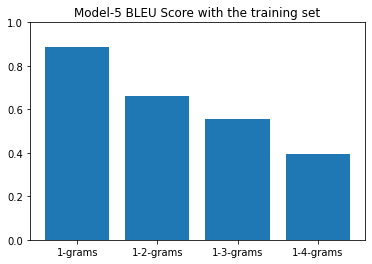


Corpus BLEU Score Train 1-1 N-Gram Weighting: 88.64
Corpus BLEU Score Train 1-2 N-Gram Weighting: 66.32
Corpus BLEU Score Train 1-3 N-Gram Weighting: 55.48
Corpus BLEU Score Train 1-4 N-Gram Weighting: 39.56


In [ ]:
# generate a graph to show the impact of weighting on BLEU score for test set
plt.bar(x = bleu_train_dict.keys(), height = bleu_train_dict.values())
plt.title("Model-5 BLEU Score with the training set")
plt.ylim((0,1))
plt.show()

# print n-gram scoring scores for train
print("\nCorpus BLEU Score Train 1-1 N-Gram Weighting: {:.2f}".format(train_bleu_score_1*100))
print("Corpus BLEU Score Train 1-2 N-Gram Weighting: {:.2f}".format(train_bleu_score_2*100))
print("Corpus BLEU Score Train 1-3 N-Gram Weighting: {:.2f}".format(train_bleu_score_3*100))
print("Corpus BLEU Score Train 1-4 N-Gram Weighting: {:.2f}".format(train_bleu_score_4*100))

Test

In [ ]:
smoothie = SmoothingFunction().method7

# [actual, predicted, weights, smoothing function]

actual  = prediction_test_df_model5['Reference']
predict = prediction_test_df_model5['Candidate']

bleu_test_dict = {}

# dict for graphing
bleu_test_dict['1-grams']   = corpus_bleu(actual, predict, weights=(1,0,0,0), smoothing_function=smoothie)
bleu_test_dict['1-2-grams'] = corpus_bleu(actual, predict, weights=(0.5,0.5,0,0), smoothing_function=smoothie)
bleu_test_dict['1-3-grams'] = corpus_bleu(actual, predict, weights=(0.3,0.3,0.3,0), smoothing_function=smoothie)
bleu_test_dict['1-4-grams'] = corpus_bleu(actual, predict, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie)

# get scores for printing
test_bleu_score_1 = corpus_bleu(actual, predict, weights=(1,0,0,0), smoothing_function=smoothie)
test_bleu_score_2 = corpus_bleu(actual, predict, weights=(0.5,0.5,0,0), smoothing_function=smoothie)
test_bleu_score_3 = corpus_bleu(actual, predict, weights=(0.3,0.3,0.3,0), smoothing_function=smoothie)
test_bleu_score_4 = corpus_bleu(actual, predict, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie)

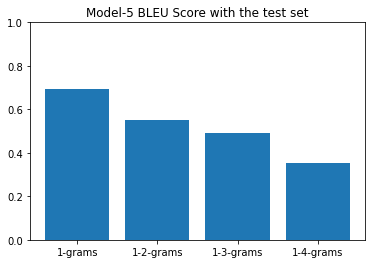


Corpus BLEU Score Test 1-1 N-Gram Weighting: 69.44
Corpus BLEU Score Test 1-2 N-Gram Weighting: 55.15
Corpus BLEU Score Test 1-3 N-Gram Weighting: 48.91
Corpus BLEU Score Test 1-4 N-Gram Weighting: 35.40


In [ ]:
# generate a graph to show the impact of weighting on BLEU score for test set
plt.bar(x = bleu_test_dict.keys(), height = bleu_test_dict.values())
plt.title("Model-5 BLEU Score with the test set")
plt.ylim((0,1))
plt.show()

# print n-gram scoring scores for train
print("\nCorpus BLEU Score Test 1-1 N-Gram Weighting: {:.2f}".format(test_bleu_score_1*100))
print("Corpus BLEU Score Test 1-2 N-Gram Weighting: {:.2f}".format(test_bleu_score_2*100))
print("Corpus BLEU Score Test 1-3 N-Gram Weighting: {:.2f}".format(test_bleu_score_3*100))
print("Corpus BLEU Score Test 1-4 N-Gram Weighting: {:.2f}".format(test_bleu_score_4*100))

### Word Error Rate
Training

In [8]:
# index = random.randint(0, len(actual)) 

actual  = prediction_train_df_model5['Reference']
predict = prediction_train_df_model5['Candidate']

# count how many sentences in the corpus have at least 1 incorrect word
count = 0
for i, j in zip(actual, predict):
    if wer_score(i, j, print_matrix=False) == 0:
        pass
    else:
        count += 1
print("Number of sentences with errors:", count)
print("Percentage of correct sentences: {:.2f}%".format(100-(count / len(actual) * 100)))

Number of sentences with errors: 2831
Percentage of correct sentences: 81.13%


In [9]:
actual  = prediction_test_df_model5['Reference']
predict = prediction_test_df_model5['Candidate']

# count how many sentences in the corpus have at least 1 incorrect word
count = 0
for i, j in zip(actual, predict):
    if wer_score(i, j, print_matrix=False) == 0:
        pass
    else:
        count += 1
print("Number of sentences with errors:", count)
print("Percentage of correct sentences: {:.2f}%".format(100-(count / len(actual) * 100)))

Number of sentences with errors: 7745
Percentage of correct sentences: 48.37%


In [ ]:
actual  = prediction_test_df_model5['Reference']
predict = prediction_test_df_model5['Candidate']

# count how many sentences in the corpus have less than 3 incorrect words
count = 0
for i, j in zip(actual, predict):
    if wer_score(i, j, print_matrix=False) <= 3:
        pass
    else:
        count += 1
print("Number of sentences with errors:", count)
print("Percentage of correct sentences: {:.2f}%".format(100-(count / len(actual) * 100)))

Number of sentences with errors: 6931
Percentage of correct sentences: 53.79%


### Precision, Accuracy, Recall, F1 Score

In [ ]:
actual  = prediction_train_df_model5['Reference']
predict = prediction_train_df_model5['Candidate']

print('Accuracy: ', round(accuracy_score(actual, predict),2))
print('Precision:', round(precision_score(actual, predict, average='weighted', zero_division=0),2))
print('Recall:   ', round(recall_score(actual, predict, average='weighted', zero_division=0),2))
print('F! Score: ', round(f1_score(actual, predict, average='weighted', zero_division=0),2))

Accuracy:  0.81
Precision: 0.79
Recall:    0.81
F! Score:  0.79


In [ ]:
actual  = prediction_test_df_model5['Reference']
predict = prediction_test_df_model5['Candidate']

print('Accuracy: ', round(accuracy_score(actual, predict),2))
print('Precision:', round(precision_score(actual, predict, average='weighted', zero_division=0),2))
print('Recall:   ', round(recall_score(actual, predict, average='weighted', zero_division=0),2))
print('F! Score: ', round(f1_score(actual, predict, average='weighted', zero_division=0),2))

Accuracy:  0.48
Precision: 0.48
Recall:    0.48
F! Score:  0.48


### GLEU
Training

In [ ]:
actual  = [prediction_train_df_model5["Reference"]]
predict = [prediction_train_df_model5["Candidate"]]

train_gleu_score = corpus_gleu([actual], predict)

print("Corpus GLEU Score Train: {:.2f}".format(train_gleu_score*100))

Corpus GLEU Score Train: 60.27


Test

In [ ]:
actual  = [prediction_test_df_model5["Reference"]]
predict = [prediction_test_df_model5["Candidate"]]

test_gleu_score = corpus_gleu([actual], predict)

print("Corpus GLEU Score Test: {:.2f}".format(test_gleu_score*100))

Corpus GLEU Score Test: 22.04


### NIST
Training

In [ ]:
# [[actual], predicted]

actual  = [prediction_train_df_model5["Reference"]]
predict = [prediction_train_df_model5["Candidate"]]

# get scores for printing
train_nist_score = corpus_nist([actual], predict)
print("Corpus NIST Score Train: {}".format(train_nist_score))

Corpus NIST Score Train: 4.2699100423918285e-05


Test

In [ ]:
# [[actual], predicted]

actual  = [prediction_test_df_model5["Reference"]]
predict = [prediction_test_df_model5["Candidate"]]

# get scores for printing
test_nist_score = corpus_nist([actual], predict)
print("Corpus NIST Score Test: {}".format(test_nist_score))

Corpus NIST Score Test: 0.00014312391538997329


### METEOR


Training

In [ ]:
index = random.randint(0, len(prediction_train_df_ckpt2))

actual  = prediction_train_df_model5['Reference'][index]
predict = prediction_train_df_model5['Candidate'][index]

print("Meteor Score for sentence", index, ":", round(meteor_score([actual], predict),4))

Meteor Score for sentence 10945 : 0.7182


In [ ]:
actual  = prediction_train_df_model5['Reference']
predict = prediction_train_df_model5['Candidate']

count = 0
for i, j in zip(actual, predict):
    if round(meteor_score([i], j), 1) > 0.5:
        count += 1
print("Sentences with a METEOR Score > 5:", count)

Sentences with a METEOR Score > 5: 13704


Test

In [ ]:
actual  = prediction_test_df_model5['Reference']
predict = prediction_test_df_model5['Candidate']

count = 0
for i, j in zip(actual, predict):
    if round(meteor_score([i], j), 1) > 0.5:
        count += 1
print("Sentences with a METEOR Score > 5:", count)

Sentences with a METEOR Score > 5: 8773


## Sentence Level Predictions

In [21]:
# model-5 test set predictions

smoothie = SmoothingFunction().method7

actual  = prediction_test_df_model5['Reference']
predict = prediction_test_df_model5['Candidate']
source  = prediction_test_df_model5['Source']

# lets find a random example from the test dataset using the random module to test the accuracy of the sentence
index = random.randint(0, len(actual))

# show a translation from the test dataset
sentence = source[index]
print("Input sentence: {}".format(sentence))
predicted_sentence = predict[index]
#predicted_sentence = translate(sentence)
print("Expected sentence: {}".format((actual[index].replace(" ", ""))))
print("Output sentence:   {} \n".format(predicted_sentence.replace(" ","")))

# set-up for BLEU sentence level eval
reference = actual[index].split()
candidate = predicted_sentence.split()

score = sentence_bleu(reference, candidate, weights=[1,0,0,0], smoothing_function=smoothie)
print("BLEU Sentence Score: {:.2f}".format(score))
print("Reference:", reference)
print("Candidate:", candidate)
print("\nSentence Index:", index)

Input sentence: if only there was a way to automate this."
Expected sentence: 除非有个自动化的方式来整理。”
Output sentence:   除非有个自动化的方式来整理。” 

BLEU Sentence Score: 0.64
Reference: ['除非', '有个', '自动化', '的', '方式', '来', '整理', '。', '”']
Candidate: ['除非', '有个', '自动化', '的', '方式', '来', '整理', '。', '”']

Sentence Index: 4404


-------------------------------------------------------------------------------------------

## Model-7 Predictions and Testing 

### Setting up the Training and Test datasets
File was renamed since creation to differentiate the model

In [ ]:
%%time

"""
Model-2 BLEU Corpus Test
w/ train + test
"""
training_sample = en_array[:15000]

train_list = []
sentences = training_sample

for i in sentences:
    translation = translate(i)
    train_list.append(translation)

CPU times: user 10h 40min 9s, sys: 18min 13s, total: 10h 58min 22s
Wall time: 10h 49min 42s


In [ ]:
prediction_train_df = pd.DataFrame({"Candidate": [], "Reference": []})

for i in train_list:
    prediction_train_df["Candidate"] = train_list
    prediction_train_df["Reference"] = zh_array[:15000]
    prediction_train_df["Source"]    = en_array[:15000]

In [ ]:
prediction_train_df.head(5)

,Candidate,Reference,Source
0,我们 有 感应 阶段 ， 计算 阶段 和 非 视觉 界面 。,我们 有 感应 阶段 ， 计算 阶段 和 非 视觉 界面 。,"we have perception, computation and non-visual..."
1,这令 他们 不是 很 完美 。 这 也 也 不是 最 完美 。,这三家 公司 还 不是 很 完美 ， 他们 代表 了 我 的 想法 。,so these three are not perfect -- they're ideas.
2,你 為 什麼 不能 來 ?,你 為 什麼 不能 來 ?,why can't you come?
3,我 又 重新 回到 了 TED 的 讲台 。,我 又 重新 回到 了 TED 的 讲台 。,i'm back here on the ted stage again.
4,谢谢 你 答应 到来 。,谢谢 你 答应 到来 。,thanks for agreeing to come.


In [ ]:
%%time
"""
Model-2 BLEU Corpus Test
w/ train + test
"""

test_list = []
sentences = en_array_test[:15000]

for i in sentences:
    translation = translate(i)
    test_list.append(translation)

CPU times: user 7h 44min 47s, sys: 13min 20s, total: 7h 58min 8s
Wall time: 7h 51min 58s


In [ ]:
prediction_df = pd.DataFrame({"Candidate": [], "Reference": []})

for i in test_list, zh_array_test:
    prediction_df["Candidate"] = test_list
    prediction_df["Reference"] = zh_array_test[:15000]
    prediction_df["Source"]    = en_array_test[:15000]

In [ ]:
#prediction_df.to_csv("../content/gdrive/MyDrive/NMT-files/model2_prediction_data.csv", index=False)
prediction_test_df = pd.read_csv("../content/gdrive/MyDrive/NMT-files/model2_prediction_data.csv")

In [ ]:
prediction_test_df.head(5)

,Candidate,Reference,Source
0,它们 其实 就是 他们 结合 的 大 区域 ， 就是 这些 飞机 上 。,它们 都 跟 这 只 袋鼠 差不多 ， 它们 都 在 “ 弹跳 ”,"they all work like this kangaroo, they bounce."
1,我 是 问 了 我们 找到 了 所有 问题 。,我来 回答 一个 大家 都 问过 的 问题 。,i have the answer to a question that we've all...
2,噢 ， 这 真是 太好了 。,很 好,"yeah, that's great."
3,第二种 是 鼓掌 第二种 原因 。,这个 观念 还 在 萌芽 阶段 ，,the idea is embryonic.
4,当时 这 是 我 在 工厂 的 这个 美国,这 是 我 的 父亲 在 越南,this was my father in vietnam.


### Load the files

In [10]:
prediction_train_df_model7 = pd.read_csv("../datasets/model2_prediction_train_data.csv")
prediction_test_df_model7 = pd.read_csv("../datasets/model2_prediction_test_data.csv")

if len(prediction_train_df_model7.columns) > 0:
    print("Training File Loaded")
if len(prediction_test_df_model7.columns) > 0:
    print("Test File Loaded")

Training File Loaded
Test File Loaded


### BLEU

Training Dataset

In [ ]:
smoothie = SmoothingFunction().method7

# [actual, predicted, weights, smoothing function]

actual  = prediction_train_df_model7['Reference']
predict = prediction_train_df_model7['Candidate']

bleu_train_dict = {}

# dict for graphing
bleu_train_dict['1-grams']   = corpus_bleu(actual, predict, weights=(1,0,0,0), smoothing_function=smoothie)
bleu_train_dict['1-2-grams'] = corpus_bleu(actual, predict, weights=(0.5,0.5,0,0), smoothing_function=smoothie)
bleu_train_dict['1-3-grams'] = corpus_bleu(actual, predict, weights=(0.3,0.3,0.3,0), smoothing_function=smoothie)
bleu_train_dict['1-4-grams'] = corpus_bleu(actual, predict, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie)

# get scores for printing
train_bleu_score_1 = corpus_bleu(actual, predict, weights=(1,0,0,0), smoothing_function=smoothie)
train_bleu_score_2 = corpus_bleu(actual, predict, weights=(0.5,0.5,0,0), smoothing_function=smoothie)
train_bleu_score_3 = corpus_bleu(actual, predict, weights=(0.3,0.3,0.3,0), smoothing_function=smoothie)
train_bleu_score_4 = corpus_bleu(actual, predict, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie)

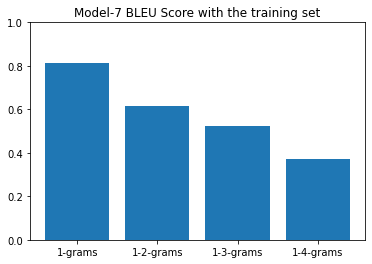


Corpus BLEU Score Train 1-1 N-Gram Weighting: 81.38
Corpus BLEU Score Train 1-2 N-Gram Weighting: 61.52
Corpus BLEU Score Train 1-3 N-Gram Weighting: 52.30
Corpus BLEU Score Train 1-4 N-Gram Weighting: 37.31


In [ ]:
# generate a graph to show the impact of weighting on BLEU score for training set
plt.bar(x = bleu_train_dict.keys(), height = bleu_train_dict.values())
plt.title("Model-7 BLEU Score with the training set")
plt.ylim((0,1))
plt.show()

# print n-gram scoring scores for train
print("\nCorpus BLEU Score Train 1-1 N-Gram Weighting: {:.2f}".format(train_bleu_score_1*100))
print("Corpus BLEU Score Train 1-2 N-Gram Weighting: {:.2f}".format(train_bleu_score_2*100))
print("Corpus BLEU Score Train 1-3 N-Gram Weighting: {:.2f}".format(train_bleu_score_3*100))
print("Corpus BLEU Score Train 1-4 N-Gram Weighting: {:.2f}".format(train_bleu_score_4*100))

Test Dataset

In [ ]:
smoothie = SmoothingFunction().method7

# [actual, predicted, weights, smoothing function]

actual  = prediction_test_df_model7['Reference']
predict = prediction_test_df_model7['Candidate']

bleu_test_dict = {}

# dict for graphing
bleu_test_dict['1-grams']   = corpus_bleu(actual, predict, weights=(1,0,0,0), smoothing_function=smoothie)
bleu_test_dict['1-2-grams'] = corpus_bleu(actual, predict, weights=(0.5,0.5,0,0), smoothing_function=smoothie)
bleu_test_dict['1-3-grams'] = corpus_bleu(actual, predict, weights=(0.3,0.3,0.3,0), smoothing_function=smoothie)
bleu_test_dict['1-4-grams'] = corpus_bleu(actual, predict, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie)

# get scores for printing
test_bleu_score_1 = corpus_bleu(actual, predict, weights=(1,0,0,0), smoothing_function=smoothie)
test_bleu_score_2 = corpus_bleu(actual, predict, weights=(0.5,0.5,0,0), smoothing_function=smoothie)
test_bleu_score_3 = corpus_bleu(actual, predict, weights=(0.3,0.3,0.3,0), smoothing_function=smoothie)
test_bleu_score_4 = corpus_bleu(actual, predict, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie)

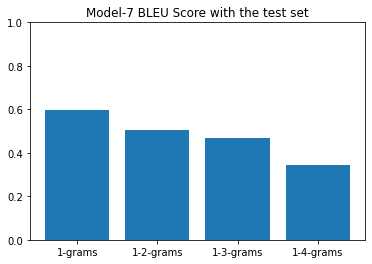


Corpus BLEU Score Test 1-1 N-Gram Weighting: 59.59
Corpus BLEU Score Test 1-2 N-Gram Weighting: 50.37
Corpus BLEU Score Test 1-3 N-Gram Weighting: 46.66
Corpus BLEU Score Test 1-4 N-Gram Weighting: 34.38


In [ ]:
# generate a graph to show the impact of weighting on BLEU score for test set
plt.bar(x = bleu_test_dict.keys(), height = bleu_test_dict.values())
plt.title("Model-7 BLEU Score with the test set")
plt.ylim((0,1))
plt.show()

# print n-gram scoring scores for train
print("\nCorpus BLEU Score Test 1-1 N-Gram Weighting: {:.2f}".format(test_bleu_score_1*100))
print("Corpus BLEU Score Test 1-2 N-Gram Weighting: {:.2f}".format(test_bleu_score_2*100))
print("Corpus BLEU Score Test 1-3 N-Gram Weighting: {:.2f}".format(test_bleu_score_3*100))
print("Corpus BLEU Score Test 1-4 N-Gram Weighting: {:.2f}".format(test_bleu_score_4*100))

In [16]:
# model-2 training set predictions
smoothie = SmoothingFunction().method7

actual  = prediction_test_df_model7['Reference']
predict = prediction_test_df_model7['Candidate']
source  = prediction_test_df_model7['Source']

# lets find a random example from the test dataset using the random module to test the accuracy of the sentence
index = random.randint(0, len(actual))

# show a translation from the test dataset
sentence = source[index]
print("Input sentence: {}".format(sentence))
predicted_sentence = predict[index]
#predicted_sentence = translate(sentence)
print("Expected sentence: {}".format((actual[index].replace(" ", ""))))
print("Output sentence:   {} \n".format(predicted_sentence.replace(" ","")))

# set-up for BLEU sentence level eval
reference = actual[index].split()
candidate = predicted_sentence.split()

score = sentence_bleu(reference, candidate, weights=[1,0,0,0], smoothing_function=smoothie)
print("BLEU Sentence Score: {:.2f}".format(score))
print("Reference:", reference)
print("Candidate:", candidate)
print("\nSentence Index:", index)

Input sentence: i kept finding myself at her page.
Expected sentence: 我不停地发现自己在她的页面。
Output sentence:   我把她的來信放在我的房間裡了。 

BLEU Sentence Score: 0.58
Reference: ['我', '不停', '地', '发现自己', '在', '她', '的', '页面', '。']
Candidate: ['我', '把', '她', '的', '來', '信放在', '我', '的', '房間裡', '了', '。']

Sentence Index: 1528


### Word Error Rate
This metric is only really useful for word-for-word comparisons  
Is adapted for a corpus

Training

In [17]:
actual  = prediction_train_df_model7['Reference']
predict = prediction_train_df_model7['Candidate']

# count how many sentences in the corpus have at least 1 incorrect word
count = 0
for i, j in zip(actual, predict):
    if wer_score(i, j, print_matrix=False) == 0:
        pass
    else:
        count += 1
print("Number of sentences with errors:", count)
print("Percentage of correct sentences: {:.2f}%".format(100-(count / len(actual) * 100)))

Number of sentences with errors: 3386
Percentage of correct sentences: 77.43%


Test

In [18]:
actual  = prediction_test_df_model7['Reference']
predict = prediction_test_df_model7['Candidate']

# count how many sentences in the test corpus have at least 1 incorrect word
count = 0
for i, j in zip(actual, predict):
    if wer_score(i, j, print_matrix=False) == 0:
        pass
    else:
        count += 1
print("Number of sentences with errors:", count)
print("Percentage of correct sentences: {:.2f}%".format(100-(count / len(actual) * 100)))

Number of sentences with errors: 14738
Percentage of correct sentences: 1.75%


In [ ]:
actual  = prediction_test_df_model7['Reference']
predict = prediction_test_df_model7['Candidate']

# count how many sentences in the test corpus have less than 3 incorrect words
count = 0
for i, j in zip(actual, predict):
    if wer_score(i, j, print_matrix=False) <= 3:
        pass
    else:
        count += 1
print("Number of sentences with errors:", count)
print("Percentage of correct sentences: {:.2f}%".format(100-(count / len(actual) * 100)))

Number of sentences with errors: 14283
Percentage of correct sentences: 4.78%


### Precision, Accuracy, Recall, F1 Score

In [ ]:
actual  = prediction_train_df_model7['Reference']
predict = prediction_train_df_model7['Candidate']

print('Accuracy: ', round(accuracy_score(actual, predict),2))
print('Precision:', round(precision_score(actual, predict, average='weighted', zero_division=0),2))
print('Recall:   ', round(recall_score(actual, predict, average='weighted', zero_division=0),2))
print('F! Score: ', round(f1_score(actual, predict, average='weighted', zero_division=0),2))

Accuracy:  0.77
Precision: 0.77
Recall:    0.77
F! Score:  0.77


In [ ]:
actual  = prediction_test_df_model7['Reference']
predict = prediction_test_df_model7['Candidate']

print('Accuracy: ', round(accuracy_score(actual, predict),2))
print('Precision:', round(precision_score(actual, predict, average='weighted', zero_division=0),2))
print('Recall:   ', round(recall_score(actual, predict, average='weighted', zero_division=0),2))
print('F! Score: ', round(f1_score(actual, predict, average='weighted', zero_division=0),2))

Accuracy:  0.02
Precision: 0.02
Recall:    0.02
F! Score:  0.02


### GLEU

Training Data

In [ ]:
actual  = [prediction_train_df_model7["Reference"]]
predict = [prediction_train_df_model7["Candidate"]]

train_gleu_score = corpus_gleu([actual], predict)

print("Corpus GLEU Score Train: {:.2f}".format(train_gleu_score*100))

Corpus GLEU Score Train: 54.89


Test Data

In [ ]:
# [[actual], predicted]

actual  = [prediction_test_df_model7["Reference"]]
predict = [prediction_test_df_model7["Candidate"]]

# get scores for printing
test_gleu_score = corpus_gleu([actual], predict)

print("Corpus GLEU Score Test: {:.2f}".format(test_gleu_score*100))

Corpus GLEU Score Test: 0.46


In [ ]:
# model-2 training set predictions - GLEU

actual  = prediction_test_df_model7['Reference']
predict = prediction_test_df_model7['Candidate']
source  = prediction_test_df_model7['Source']

# lets find a random example from the test dataset using the 
# random module to test the accuracy of the sentence
index = random.randint(0, len(actual))

# show a translation from the test dataset
sentence = source[index]
print("Input sentence: {}".format(sentence))
predicted_sentence = predict[index]
#predicted_sentence = translate(sentence)
print("Expected sentence: {}".format((actual[index].replace(" ", ""))))
print("Output sentence:   {} \n".format(predicted_sentence.replace(" ","")))

# set-up for BLEU sentence level eval
reference = actual[index].split()
candidate = predicted_sentence.split()

score = sentence_gleu([reference], candidate)
print("GLEU Sentence Score: {:.2f}".format(score))
print("Reference:", reference)
print("Candidate:", candidate)
print("\nSentence Index:", index)

Input sentence: please help yourself to the cake.
Expected sentence: 你们自己吃蛋糕。
Output sentence:   你自己拿蛋糕吃吧。 

GLEU Sentence Score: 0.18
Reference: ['你们', '自己', '吃', '蛋糕', '。']
Candidate: ['你', '自己', '拿', '蛋糕', '吃', '吧', '。']

Sentence Index: 101


### NIST

Training

In [ ]:
# [[actual], predicted]

actual  = [prediction_train_df_model7["Reference"]]
predict = [prediction_train_df_model7["Candidate"]]

# get scores for printing
train_nist_score = corpus_nist([actual], predict)
print("Corpus NIST Score Test: {}".format(train_nist_score))

Corpus NIST Score Test: 5.103487650627232e-05


Test 

In [ ]:
# [[actual], predicted]

actual  = [prediction_test_df_model7["Reference"]]
predict = [prediction_test_df_model7["Candidate"]]

# get scores for printing
test_nist_score = corpus_nist([actual], predict)
print("Corpus NIST Score Test: {}".format(test_nist_score))

Corpus NIST Score Test: 0.00032824159447377506


### METEOR


Training

In [ ]:
index = random.randint(0, len(prediction_train_df_model7))

actual  = prediction_train_df_model7['Reference'][index]
predict = prediction_train_df_model7['Candidate'][index]

print("Meteor Score for sentence", index, ":", round(meteor_score([actual], predict),4))

Meteor Score for sentence 4573 : 0.999


In [ ]:
actual  = prediction_train_df_model7['Reference']
predict = prediction_train_df_model7['Candidate']

count = 0
for i, j in zip(actual, predict):
    if round(meteor_score([i], j), 1) > 0.5:
        count += 1
print("Sentences with a METEOR Score > 5:", count)

Sentences with a METEOR Score > 5: 13598


Test

In [ ]:
actual  = prediction_test_df_model7['Reference']
predict = prediction_test_df_model7['Candidate']

count = 0
for i, j in zip(actual, predict):
    if round(meteor_score([i], j), 1) > 0.5:
        count += 1
print("Sentences with a METEOR Score > 5:", count)

Sentences with a METEOR Score > 5: 1085


-------------------------------------------------------------------------------------------

## Sentence Level Predictions

In [ ]:
# model-2 training set predictions - NIST

actual  = prediction_train_df['Reference']
predict = prediction_train_df['Candidate']
source  = prediction_train_df['Source']

# lets find a random example from the test dataset using the random module to test the accuracy of the sentence
index = random.randint(0, len(actual))

# show a translation from the test dataset
sentence = source[index]
print("Input sentence: {}".format(sentence))
predicted_sentence = predict[index]
#predicted_sentence = translate(sentence)
print("Expected sentence: {}".format((actual[index].replace(" ", ""))))
print("Output sentence:   {} \n".format(predicted_sentence.replace(" ","")))

# set-up for BLEU sentence level eval
reference = actual[index].split()
candidate = predicted_sentence.split()

score = sentence_nist([reference], candidate)
print("NIST Sentence Score: {:.2f}".format(score))
print("Reference:", reference)
print("Candidate:", candidate)
print("\nSentence Index:", index)

Input sentence: more than 40 percent of students go on to university.
Expected sentence: 40%以上的学生去读大学。
Output sentence:   40%以上的学生去读大学。 

GLEU Sentence Score: 0.07
Reference: ['40%', '以上', '的', '学生', '去', '读', '大学', '。']
Candidate: ['40%', '以上', '的', '学生', '去', '读', '大学', '。']

Sentence Index: 13919


## Survey Evaluation of Responses

In [ ]:
survey_results_df = pd.read_csv("../content/gdrive/MyDrive/NMT-files/MSc_NMT_SurveyResults.csv")

In [ ]:
survey_results_df.head(5)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,RecipientFirstName,RecipientEmail,ExternalReference,LocationLatitude,LocationLongitude,DistributionChannel,UserLanguage,Q0,Q1_1,Q2_1,Q3_1,Q4_1,Q5_1,Q6_1,Q7_1,Q8_1,Q9_1,Q10_1,Q11_1,Q12_1,Q13_1,Q14_1,Q15_1
0,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,Recipient First Name,Recipient Email,External Data Reference,Location Latitude,Location Longitude,Distribution Channel,User Language,By answering yes to the below question and pro...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""status""}","{""ImportId"":""ipAddress""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""recipientLastName""}","{""ImportId"":""recipientFirstName""}","{""ImportId"":""recipientEmail""}","{""ImportId"":""externalDataReference""}","{""ImportId"":""locationLatitude""}","{""ImportId"":""locationLongitude""}","{""ImportId"":""distributionChannel""}","{""ImportId"":""userLanguage""}","{""ImportId"":""QID31""}","{""ImportId"":""QID53_1""}","{""ImportId"":""QID57_1""}","{""ImportId"":""QID58_1""}","{""ImportId"":""QID60_1""}","{""ImportId"":""QID62_1""}","{""ImportId"":""QID63_1""}","{""ImportId"":""QID65_1""}","{""ImportId"":""QID66_1""}","{""ImportId"":""QID67_1""}","{""ImportId"":""QID69_1""}","{""ImportId"":""QID72_1""}","{""ImportId"":""QID70_1""}","{""ImportId"":""QID71_1""}","{""ImportId"":""QID74_1""}","{""ImportId"":""QID75_1""}"
2,2021-08-26 13:11:40,2021-08-26 13:16:01,0,51.199.90.205,100,260,1,2021-08-26 13:16:01,R_1kN622KcaqMmNwi,NaN,NaN,NaN,NaN,53.3488006591796875,-1.4091033935546875,anonymous,EN,2,1,1,1,4,2,1,2,4,2,4,2,1,3,2,1
3,2021-08-26 13:19:48,2021-08-26 13:24:50,0,5.151.46.99,100,301,1,2021-08-26 13:24:50,R_aXjkUqm7dLT0Ydb,NaN,NaN,NaN,NaN,51.6016998291015625,-0.0731964111328125,anonymous,EN,2,2,1,1,4,2,1,3,2,1,2,1,1,4,1,1
4,2021-08-28 05:16:59,2021-08-28 05:19:10,0,82.132.242.250,100,130,1,2021-08-28 05:19:10,R_3KvYp13br7b1pxE,NaN,NaN,NaN,NaN,53.16510009765625,-1.48199462890625,anonymous,EN,2,1,1,1,1,1,4,1,1,1,1,1,1,1,4,NaN


In [ ]:
# don't need the second row, lets drop this first

survey_results_df = survey_results_df.drop(survey_results_df.index[1])
survey_results_df.head(5)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,RecipientFirstName,RecipientEmail,ExternalReference,LocationLatitude,LocationLongitude,DistributionChannel,UserLanguage,Q0,Q1_1,Q2_1,Q3_1,Q4_1,Q5_1,Q6_1,Q7_1,Q8_1,Q9_1,Q10_1,Q11_1,Q12_1,Q13_1,Q14_1,Q15_1
0,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,Recipient First Name,Recipient Email,External Data Reference,Location Latitude,Location Longitude,Distribution Channel,User Language,By answering yes to the below question and pro...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...
2,2021-08-26 13:11:40,2021-08-26 13:16:01,0,51.199.90.205,100,260,1,2021-08-26 13:16:01,R_1kN622KcaqMmNwi,NaN,NaN,NaN,NaN,53.3488006591796875,-1.4091033935546875,anonymous,EN,2,1,1,1,4,2,1,2,4,2,4,2,1,3,2,1
3,2021-08-26 13:19:48,2021-08-26 13:24:50,0,5.151.46.99,100,301,1,2021-08-26 13:24:50,R_aXjkUqm7dLT0Ydb,NaN,NaN,NaN,NaN,51.6016998291015625,-0.0731964111328125,anonymous,EN,2,2,1,1,4,2,1,3,2,1,2,1,1,4,1,1
4,2021-08-28 05:16:59,2021-08-28 05:19:10,0,82.132.242.250,100,130,1,2021-08-28 05:19:10,R_3KvYp13br7b1pxE,NaN,NaN,NaN,NaN,53.16510009765625,-1.48199462890625,anonymous,EN,2,1,1,1,1,1,4,1,1,1,1,1,1,1,4,NaN
5,2021-08-28 05:33:21,2021-08-28 05:35:42,0,16.162.143.149,100,140,1,2021-08-28 05:35:42,R_dcGqC0W8bAm3t61,NaN,NaN,NaN,NaN,22.2577972412109375,114.16571044921875,anonymous,EN,2,2,2,3,2,2,2,2,3,1,3,2,2,3,2,3


In [ ]:
# drop all unneccesary columns , only want the question answers
survey_results_clean = survey_results_df.drop(['StartDate','EndDate', 'Status', 'IPAddress', 'Progress', 'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId', \
                        'RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'ExternalReference', 'LocationLatitude', 'LocationLongitude', \
                        'DistributionChannel', 'UserLanguage','Q0'], axis=1)

In [ ]:
# there are some NaNs, these are left in as the added value will change our percentage
#survey_results_clean = survey_results_clean.fillna(0)
survey_results_clean.Q2_1.unique()

array(['Read the text below and rate it by how much you agree that: The text is fluent Mandarin Chinese.\n\n\n \n\n   会出现什么情况呢？',
       '1', '2', '3', '4', '5', nan], dtype=object)

In [ ]:
survey_results_clean.head(5)

,Q1_1,Q2_1,Q3_1,Q4_1,Q5_1,Q6_1,Q7_1,Q8_1,Q9_1,Q10_1,Q11_1,Q12_1,Q13_1,Q14_1,Q15_1
0,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...,Read the text below and rate it by how much yo...
2,1,1,1,4,2,1,2,4,2,4,2,1,3,2,1
3,2,1,1,4,2,1,3,2,1,2,1,1,4,1,1
4,1,1,1,1,1,4,1,1,1,1,1,1,1,4,NaN
5,2,2,3,2,2,2,2,3,1,3,2,2,3,2,3


In [ ]:
# removing the question text
survey_results = survey_results_clean.drop(survey_results_clean.index[0])

In [ ]:
# convert all values to numeric
survey_results = survey_results.apply( pd.to_numeric, errors='coerce' )

In [ ]:
survey_results.describe()

,Q1_1,Q2_1,Q3_1,Q4_1,Q5_1,Q6_1,Q7_1,Q8_1,Q9_1,Q10_1,Q11_1,Q12_1,Q13_1,Q14_1,Q15_1
count,50.000000,46.000000,46.000000,44.000000,44.000000,44.000000,43.000000,43.000000,43.000000,43.000000,42.000000,43.000000,43.000000,43.000000,41.000000
mean,2.120000,2.173913,2.217391,3.340909,2.522727,1.954545,3.000000,3.372093,3.139535,3.023256,2.071429,1.883721,2.976744,2.651163,2.487805
std,1.154229,1.101602,1.381031,1.445815,1.517167,1.413466,1.380131,1.380532,1.626878,1.371276,1.403703,1.331117,1.422412,1.412255,1.164516
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.500000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000
50%,2.000000,2.000000,2.000000,4.000000,2.000000,1.000000,3.000000,4.000000,3.000000,3.000000,1.500000,1.000000,3.000000,2.000000,2.000000
75%,2.000000,3.000000,3.000000,5.000000,4.000000,3.000000,4.000000,4.000000,5.000000,4.000000,2.750000,3.000000,4.000000,4.000000,3.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [ ]:
survey_results['Q2_1'].value_counts()

2.0    18
1.0    14
3.0     8
4.0     4
5.0     2
Name: Q2_1, dtype: int64

In [ ]:
survey_results.apply(pd.value_counts)

,Q1_1,Q2_1,Q3_1,Q4_1,Q5_1,Q6_1,Q7_1,Q8_1,Q9_1,Q10_1,Q11_1,Q12_1,Q13_1,Q14_1,Q15_1
1.0,16,14,19,6,17,27,7,7,10,7,21,27,8,12,10
2.0,23,18,12,9,7,5,11,4,9,10,10,4,10,10,11
3.0,3,8,7,6,7,3,8,8,3,9,3,5,9,8,12
4.0,5,4,2,10,6,5,9,14,7,9,3,4,7,7,6
5.0,3,2,6,13,7,4,8,10,14,8,5,3,9,6,2


In [ ]:
# get the percentile spread of values on a per question basis
# this is used for the creation of tables in the report

counter = 0
for i in survey_results:
    counter += 1
    s = survey_results[i]
    counts = s.value_counts()
    percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    print('Question', counter, '\n', pd.DataFrame({'counts': counts, 'percentage': percent100}),'\n')

Question 1 
    counts percentage
2      23      46.0%
1      16      32.0%
4       5      10.0%
5       3       6.0%
3       3       6.0% 

Question 2 
      counts percentage
2.0      18      39.1%
1.0      14      30.4%
3.0       8      17.4%
4.0       4       8.7%
5.0       2       4.3% 

Question 3 
      counts percentage
1.0      19      41.3%
2.0      12      26.1%
3.0       7      15.2%
5.0       6      13.0%
4.0       2       4.3% 

Question 4 
      counts percentage
5.0      13      29.5%
4.0      10      22.7%
2.0       9      20.5%
3.0       6      13.6%
1.0       6      13.6% 

Question 5 
      counts percentage
1.0      17      38.6%
5.0       7      15.9%
3.0       7      15.9%
2.0       7      15.9%
4.0       6      13.6% 

Question 6 
      counts percentage
1.0      27      61.4%
2.0       5      11.4%
4.0       5      11.4%
5.0       4       9.1%
3.0       3       6.8% 

Question 7 
      counts percentage
2.0      11      25.6%
4.0       9      20.9%
5.0       8 